In [2]:
import glob
import csv
import sys, os.path
import pandas as pd
import sklearn
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
#from torchvision import transforms
#from torch.utils.tensorboard import SummaryWriter
#from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 1000

In [4]:
# Our modules
import sys
sys.path.append('.')
sys.path.append('..')

from vae import configs, train, plot_utils, models
from vae.data import build_dataloader
from vae.latent_spaces import dimensionality_reduction, plot_spaces
from vae.reconstructions import plot_reconstructions
from vae.models import model_utils

In [5]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [6]:
classes = ['violin', 'viola', 'cello', 'double-bass',
                'clarinet', 'bass-clarinet', 'saxophone', 'flute', 'oboe', 'bassoon', 'contrabassoon',
                'french-horn', 'trombone', 'trumpet', 'tuba', 'english-horn',
                'guitar', 'mandolin', 'banjo', 'chromatic-percussion']

chromatic_perc = ['agogo-bells', 'banana-shaker', 'bass-drum', 'bell-tree', 'cabasa', 'Chinese-hand-cymbals',
                        'castanets', 'Chinese-cymbal', 'clash-cymbals', 'cowbell', 'djembe', 'djundjun', 'flexatone', 'guiro',
                        'lemon-shaker',  'motor-horn',  'ratchet', 'sheeps-toenails', 'sizzle-cymbal', 'sleigh-bells', 'snare-drum',
                        'spring-coil', 'squeaker', 'strawberry-shaker', 'surdo', 'suspended-cymbal', 'swanee-whistle',
                        'tambourine', 'tam-tam', 'tenor-drum', 'Thai-gong', 'tom-toms', 'train-whistle', 'triangle',
                        'vibraslap', 'washboard', 'whip', 'wind-chimes', 'woodblock', 'cor-anglais']

labels_list = [i for i in range(len(classes))]

In [7]:
# Create dict of classes
classes_dict = {classes[i]: classes.index(classes[i]) for i in range(len(classes))}


df = pd.DataFrame.from_dict(classes_dict, orient='index', columns=['class'])

In [8]:
df

,class
violin,0
viola,1
cello,2
double-bass,3
clarinet,4
bass-clarinet,5
saxophone,6
flute,7
oboe,8
bassoon,9


In [9]:
model_name = 'supervised_timbre'
input = 'mel_cut'
trained_epochs = 320


test_dataset, test_dataloader = build_dataloader.build_testset(input, model_name)
print('Number of files in the training dataset:', len(test_dataset))

Number of files in the training dataset: 1357


In [14]:
model = model_utils.import_model(model_name, input)

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
model.to(device)
checkpoint = torch.load(os.path.join(configs.ParamsConfig.TRAINED_MODELS_PATH, 'saved_model_' + str(trained_epochs) + "epochs.pth"),
                       torch.device('cpu'))
model.load_state_dict(checkpoint['model'])
with torch.no_grad():
    model.eval()
    
    y_pred_list = []
    y_test_list = []
    for sample_batch, file, y in test_dataloader:
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_list.append(y)
            y_test_pred, w, _ = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            y_pred_list.append(y_pred_tags.cpu().numpy())
            
            #if file[0] == 'violin_G6_1_fortissimo_arco-normal' or file[0]=='viola_G6_1_fortissimo_arco-normal': #violins
                #print(file[0])
                #plt.imshow(sample_batch[0,0,...].detach().cpu().numpy(), origin='lower', aspect=0.5)
                #plt.show()
                #plt.imshow(w[0,:,...].detach().cpu().numpy(), origin='lower')
                #plt.show()
                

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test_list]

In [15]:
model_utils.show_total_params(model)

Number of parameters: 122388
AttentionTimbreEncoder(
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (fc_1): Linear(in_features=2816, out_features=20, bias=True)
)


In [16]:
assert y_pred_list != y_test

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_pred_list)

array([[97,  4,  0,  0,  4,  0,  8, 13,  4,  0,  0,  4,  2,  3,  0,  1,
         0,  0,  2,  8],
       [ 8, 68,  2,  1,  2,  0,  3,  5,  2,  0,  1,  0,  4,  0,  1,  0,
         0,  0,  0,  0],
       [ 8,  1, 41,  0,  2,  5,  8,  1,  8,  0,  0,  0, 12,  2,  1,  0,
         0,  0,  0,  0],
       [11,  1,  2, 50,  3,  0,  0,  2,  0,  0,  0,  1, 14,  0,  1,  0,
         0,  0,  0,  0],
       [16,  4,  0,  0, 48,  4,  7,  2,  0,  0,  0,  2,  1,  0,  0,  1,
         0,  0,  0,  0],
       [ 6,  0,  0,  2,  1, 46,  1,  0,  0,  3,  0,  2, 16,  1,  1, 15,
         0,  0,  0,  0],
       [22,  7,  0,  0,  8,  0, 24,  1,  2,  0,  0,  3,  4,  1,  0,  1,
         0,  0,  0,  0],
       [10,  1,  0,  0,  4,  0,  1, 67,  1,  0,  0,  2,  2,  0,  0,  0,
         0,  0,  0,  0],
       [ 3,  0,  0,  0,  2,  0,  0,  3, 52,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [10,  0,  0,  0,  0,  1,  0,  0,  1, 38,  0, 11,  1,  0, 10,  0,
         0,  0,  0,  0],
       [ 1,  0, 20,  0,  0,  0

In [18]:
idx_class = {v: k for k, v in classes_dict.items()}

confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx_class, index=idx_class)

In [19]:
confusion_matrix_df

,violin,viola,cello,double-bass,clarinet,bass-clarinet,saxophone,flute,oboe,bassoon,contrabassoon,french-horn,trombone,trumpet,tuba,english-horn,guitar,mandolin,banjo,chromatic-percussion
violin,97,4,0,0,4,0,8,13,4,0,0,4,2,3,0,1,0,0,2,8
viola,8,68,2,1,2,0,3,5,2,0,1,0,4,0,1,0,0,0,0,0
cello,8,1,41,0,2,5,8,1,8,0,0,0,12,2,1,0,0,0,0,0
double-bass,11,1,2,50,3,0,0,2,0,0,0,1,14,0,1,0,0,0,0,0
clarinet,16,4,0,0,48,4,7,2,0,0,0,2,1,0,0,1,0,0,0,0
bass-clarinet,6,0,0,2,1,46,1,0,0,3,0,2,16,1,1,15,0,0,0,0
saxophone,22,7,0,0,8,0,24,1,2,0,0,3,4,1,0,1,0,0,0,0
flute,10,1,0,0,4,0,1,67,1,0,0,2,2,0,0,0,0,0,0,0
oboe,3,0,0,0,2,0,0,3,52,0,0,0,0,0,0,0,0,0,0,0
bassoon,10,0,0,0,0,1,0,0,1,38,0,11,1,0,10,0,0,0,0,0


<AxesSubplot:>

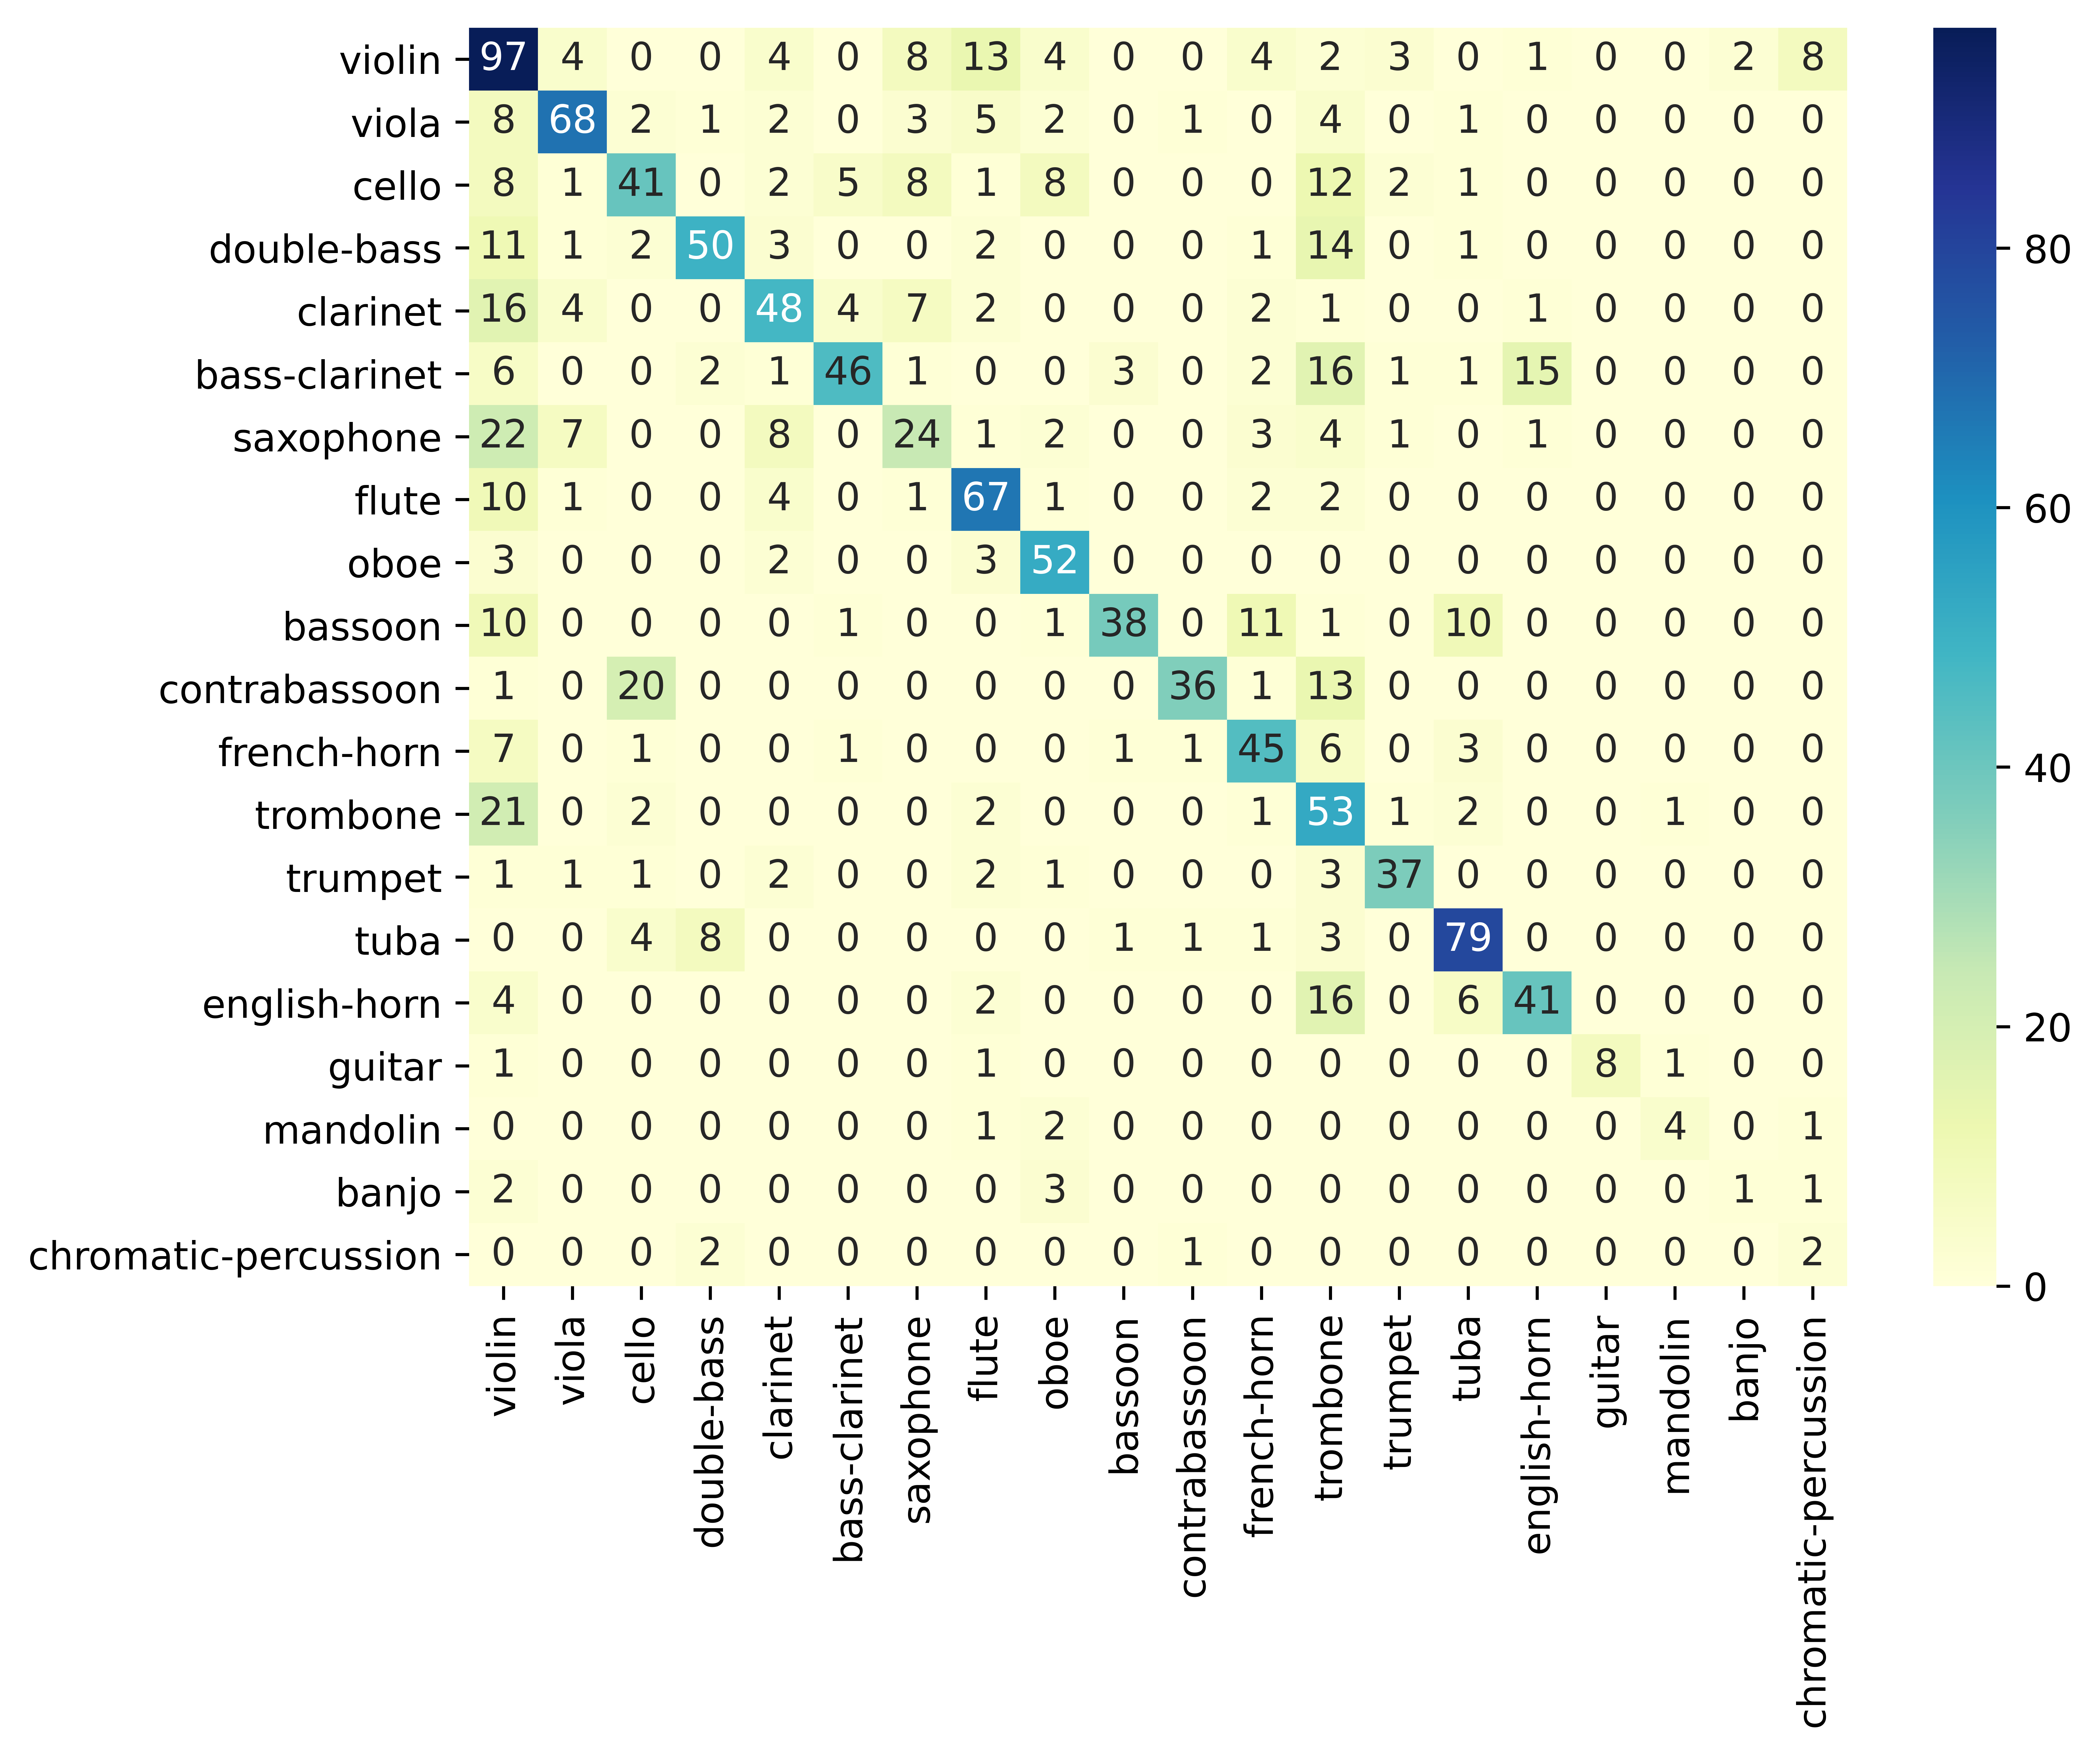

In [20]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=True, cmap="YlGnBu", ax=ax)

<AxesSubplot:>

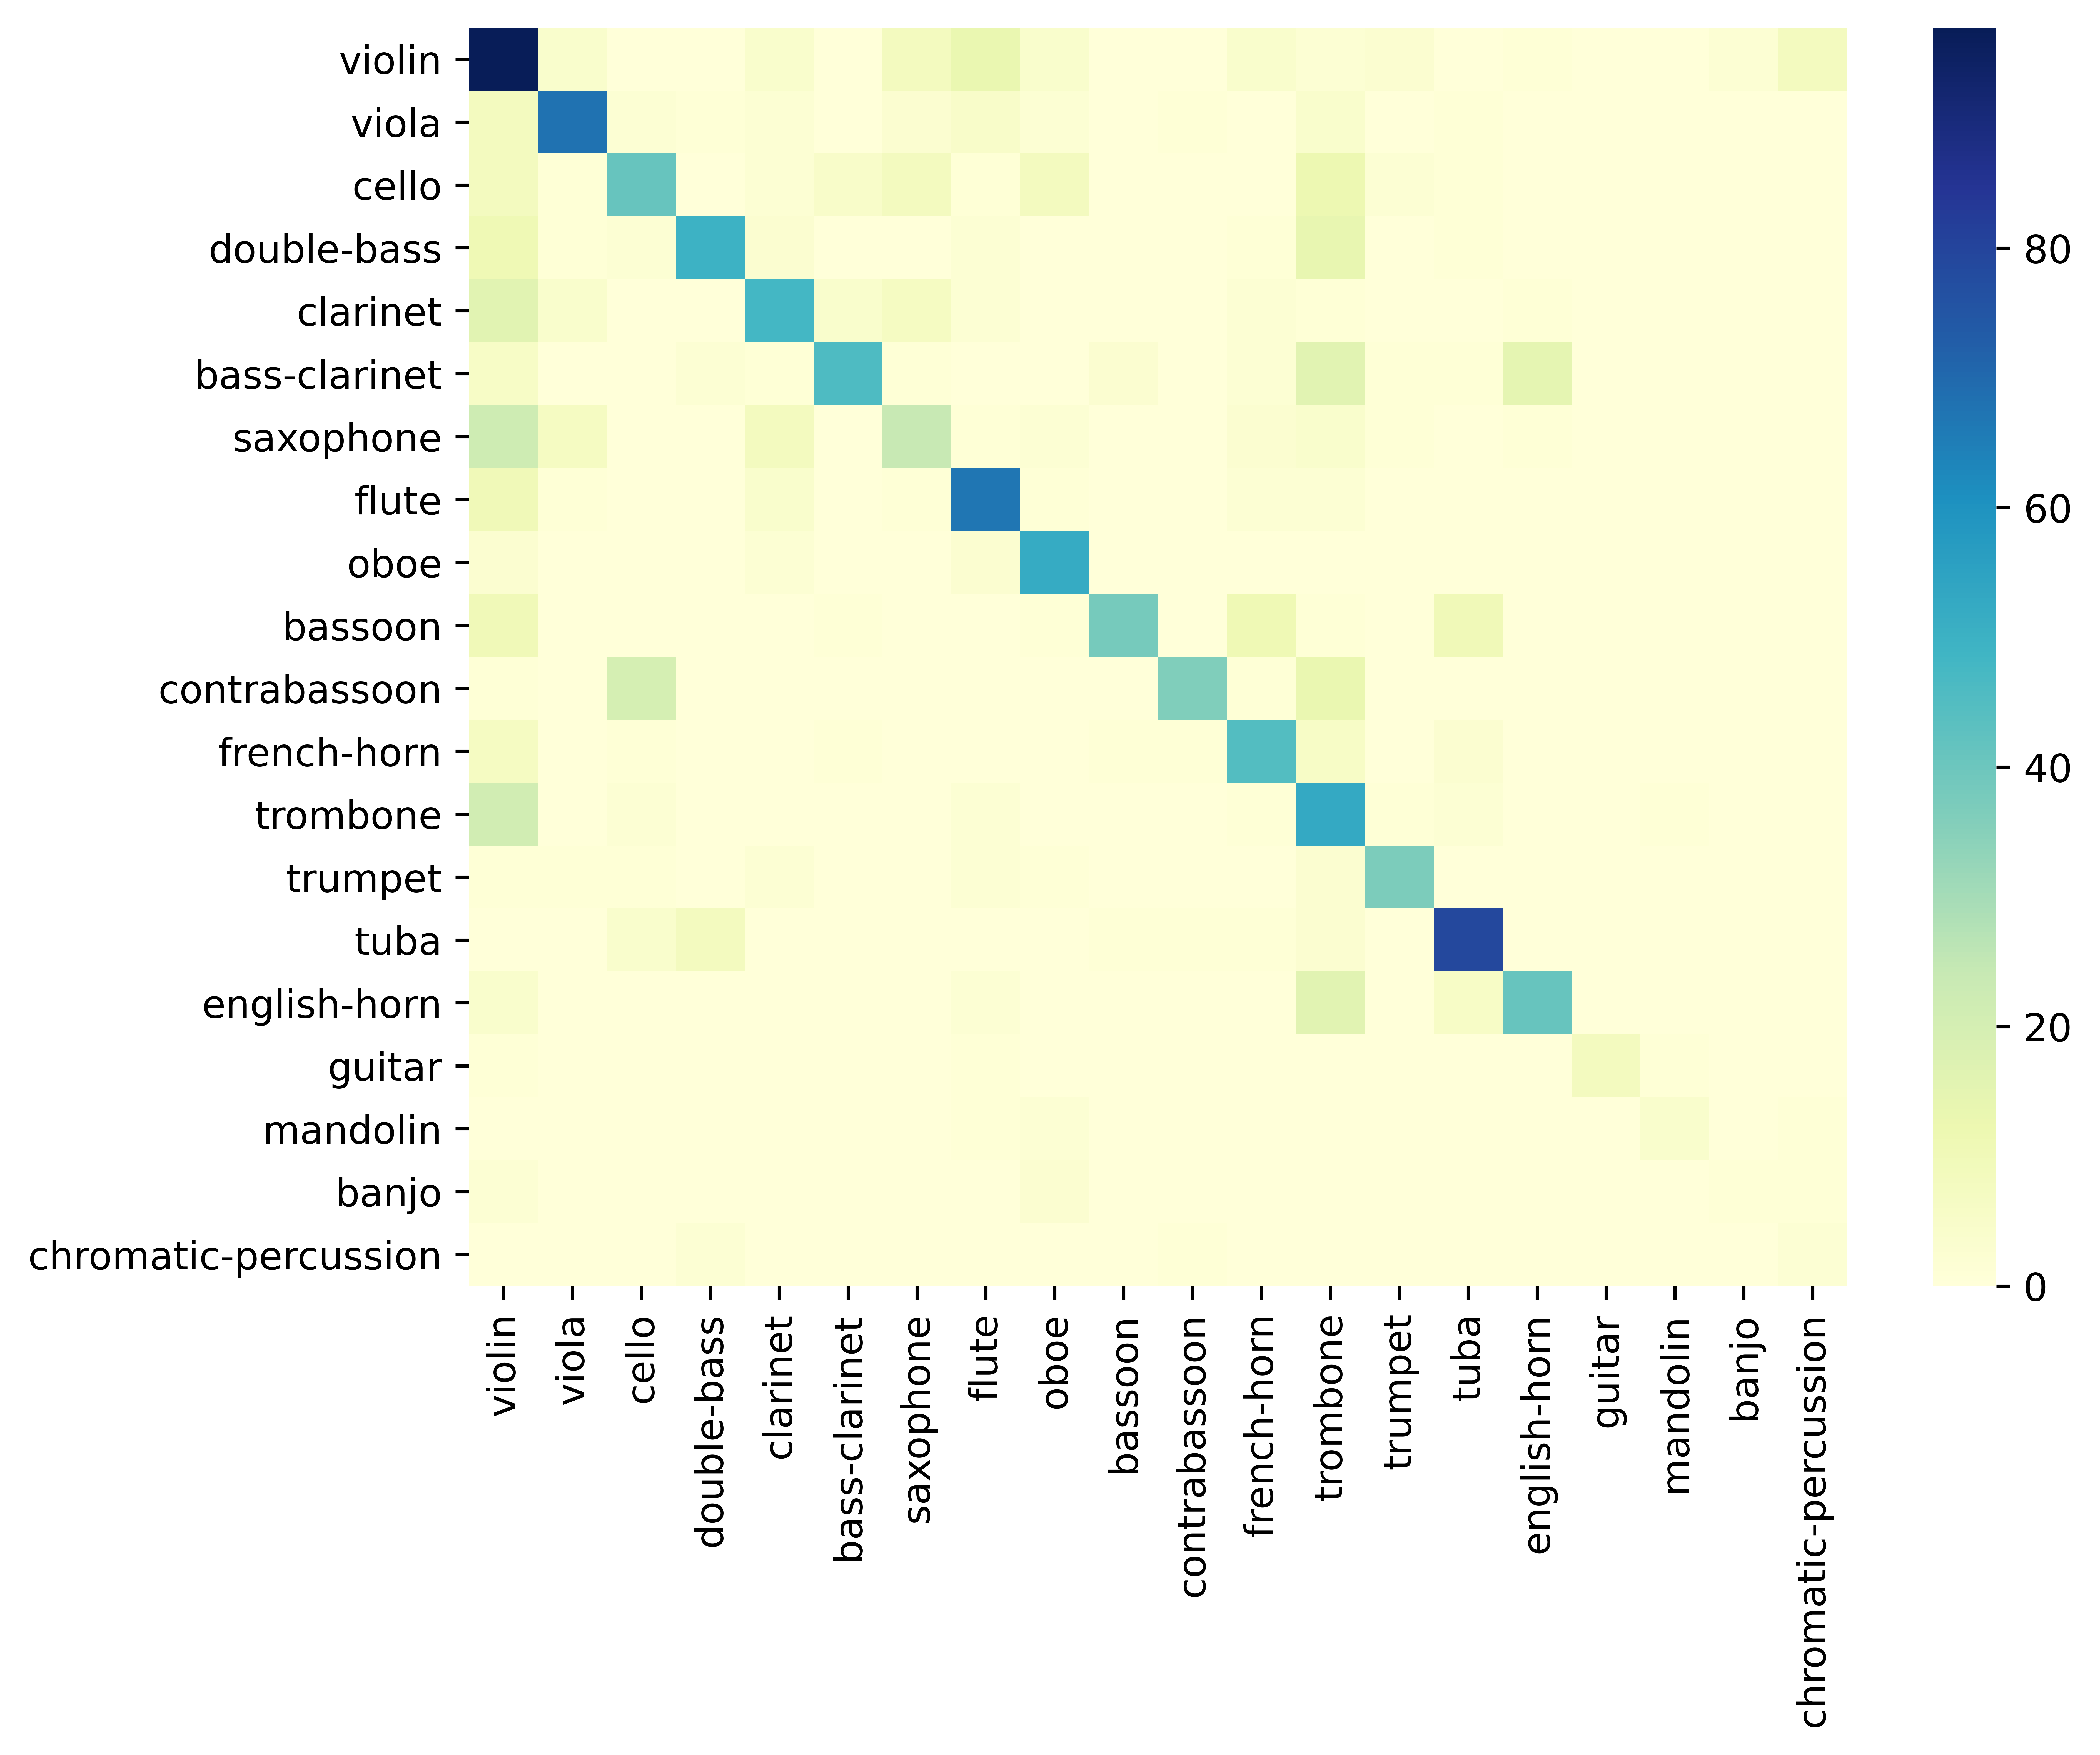

In [15]:
fig, ax = plt.subplots(figsize=(8, 6)) 
sns.heatmap(confusion_matrix_df, annot=False, cmap="YlGnBu", ax=ax)

In [16]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

122388

In [17]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.43      0.65      0.51       150
           1       0.78      0.70      0.74        97
           2       0.56      0.46      0.51        89
           3       0.79      0.59      0.68        85
           4       0.63      0.56      0.60        85
           5       0.81      0.49      0.61        94
           6       0.46      0.33      0.38        73
           7       0.66      0.76      0.71        88
           8       0.68      0.87      0.76        60
           9       0.88      0.53      0.66        72
          10       0.90      0.51      0.65        71
          11       0.62      0.69      0.65        65
          12       0.35      0.64      0.45        83
          13       0.82      0.77      0.80        48
          14       0.76      0.81      0.79        97
          15       0.69      0.59      0.64        69
          16       1.00      0.73      0.84        11
          17       0.67    

## Attention heatmaps 

The input class is a guitar_G5_very-long_forte_normal and the predicted class is a guitar


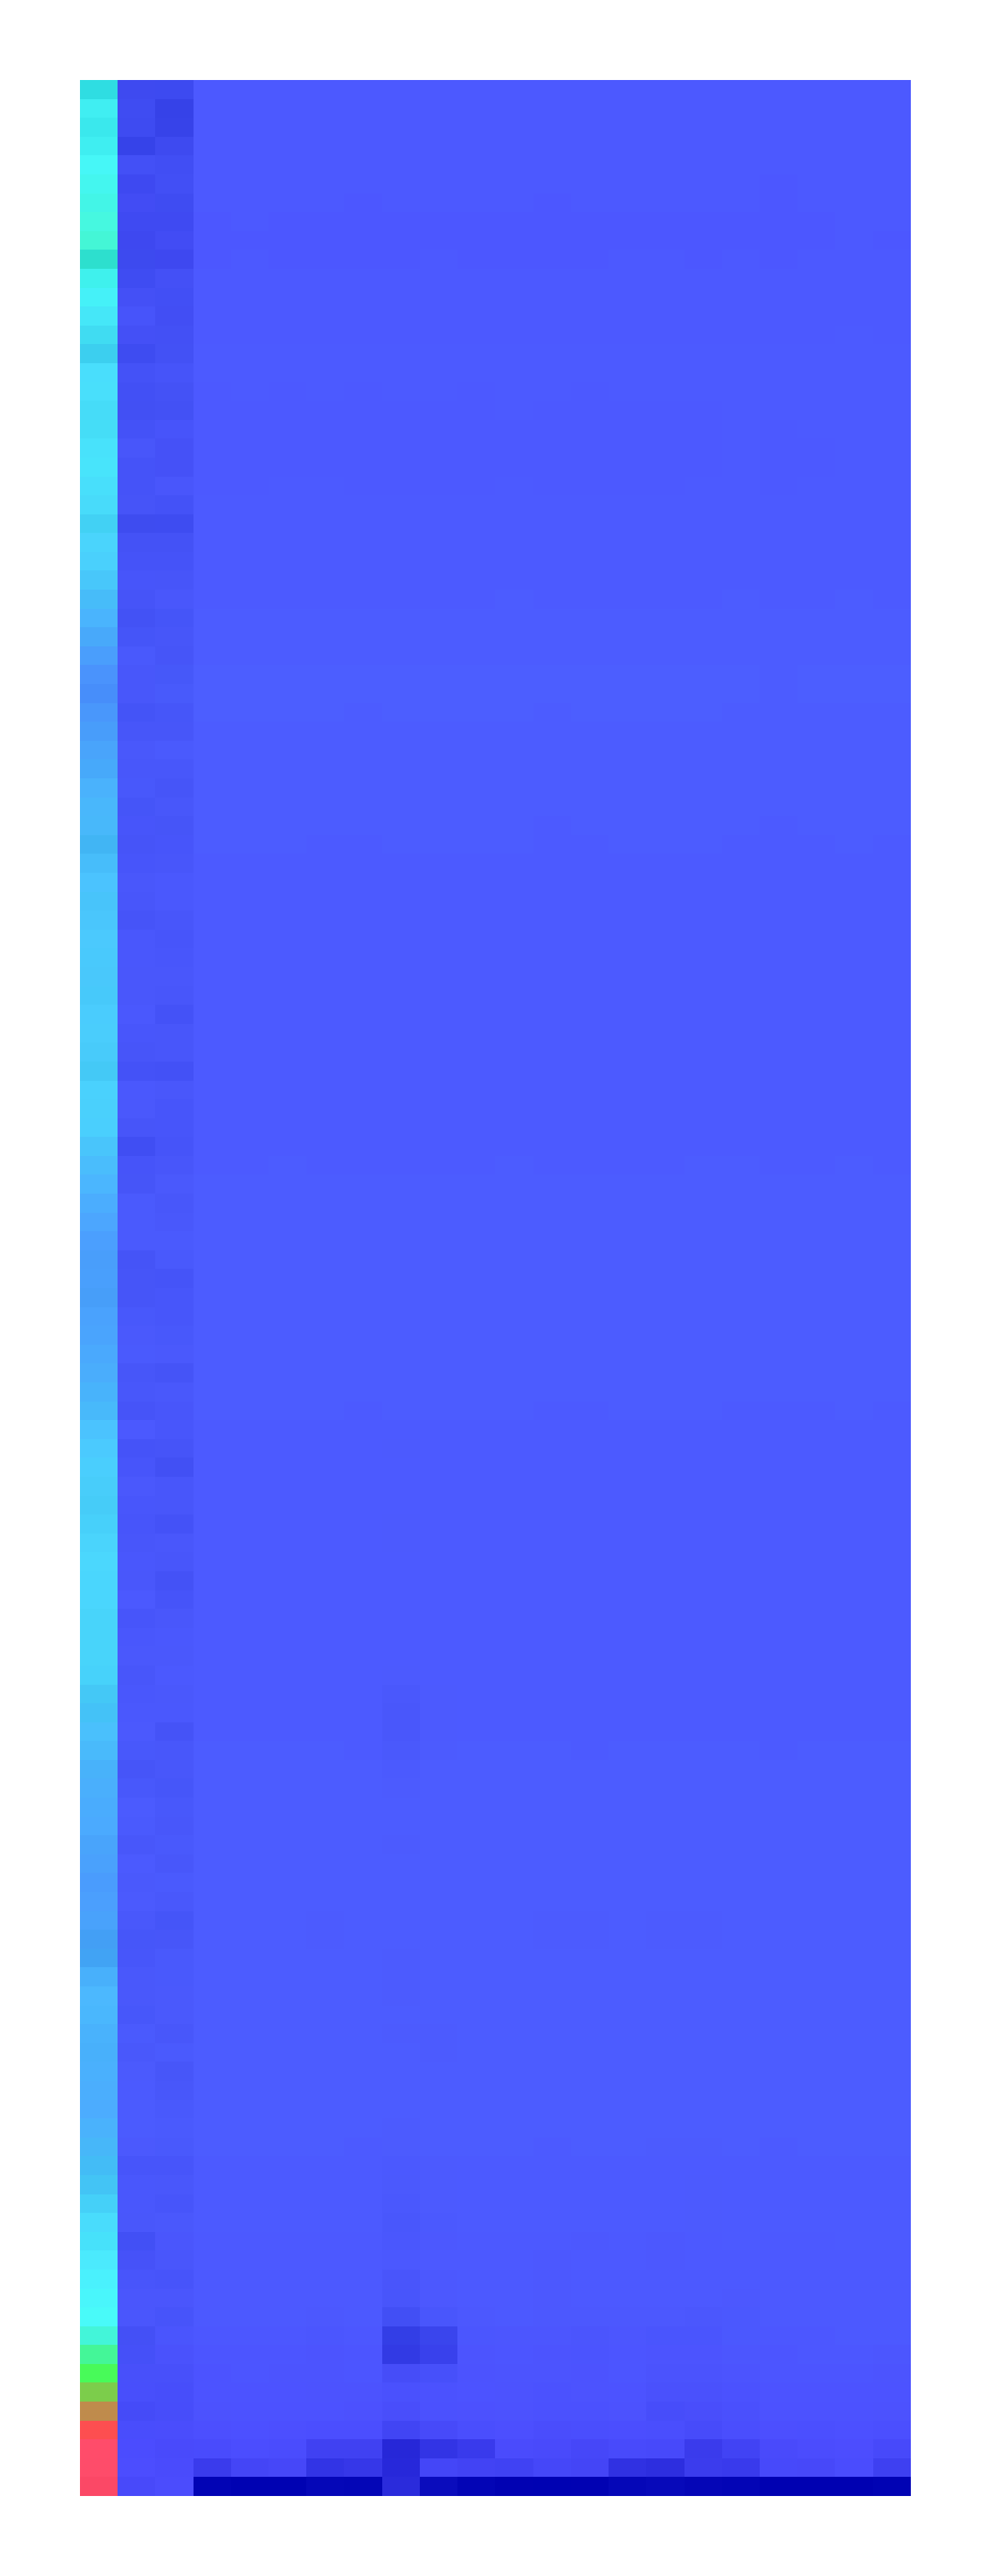

The input class is a guitar_G4_very-long_piano_normal and the predicted class is a guitar


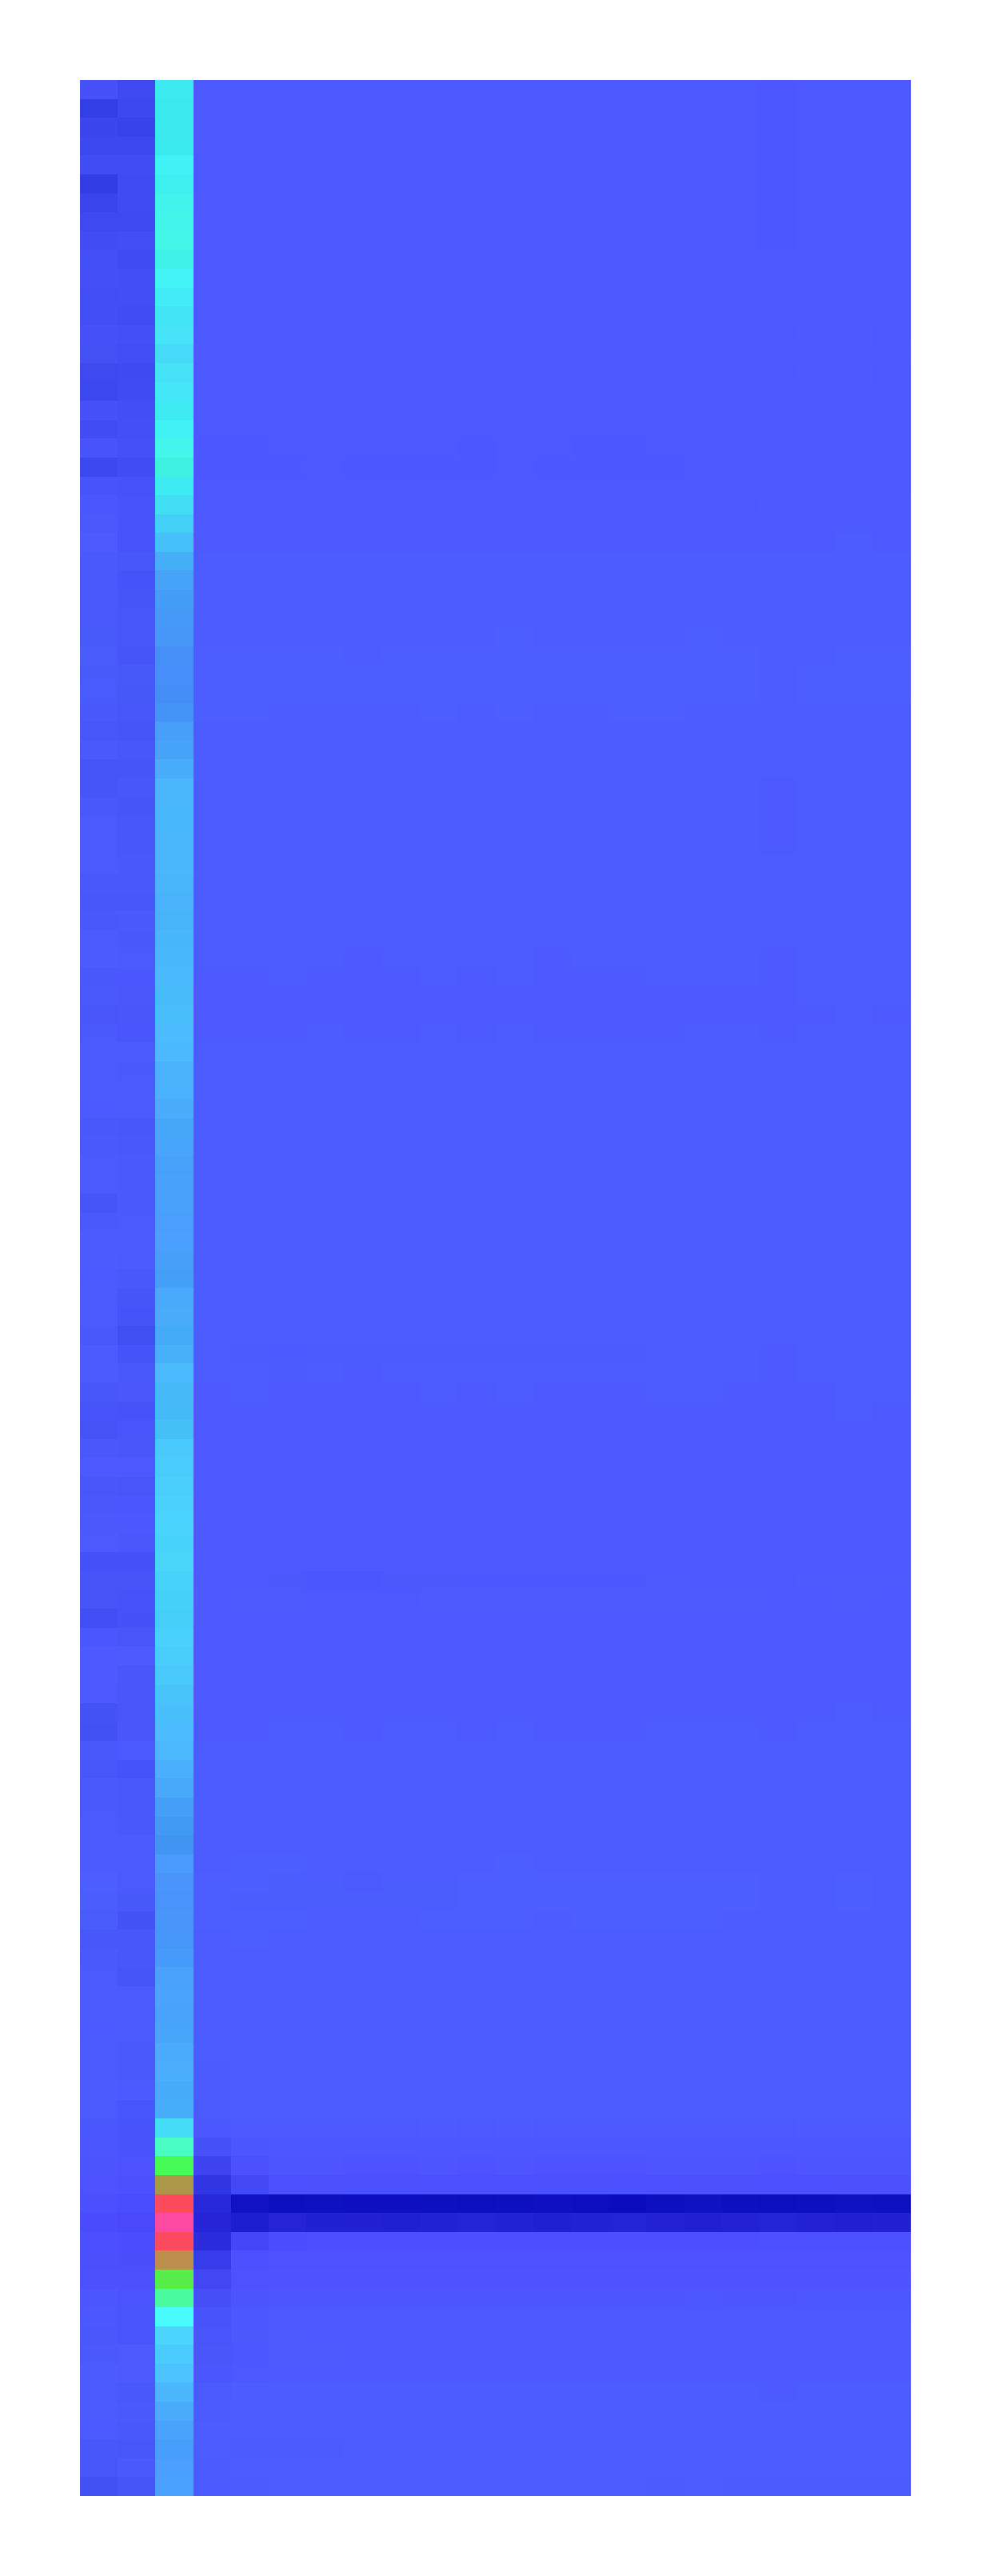

The input class is a guitar_G5_very-long_piano_harmonics and the predicted class is a mandolin


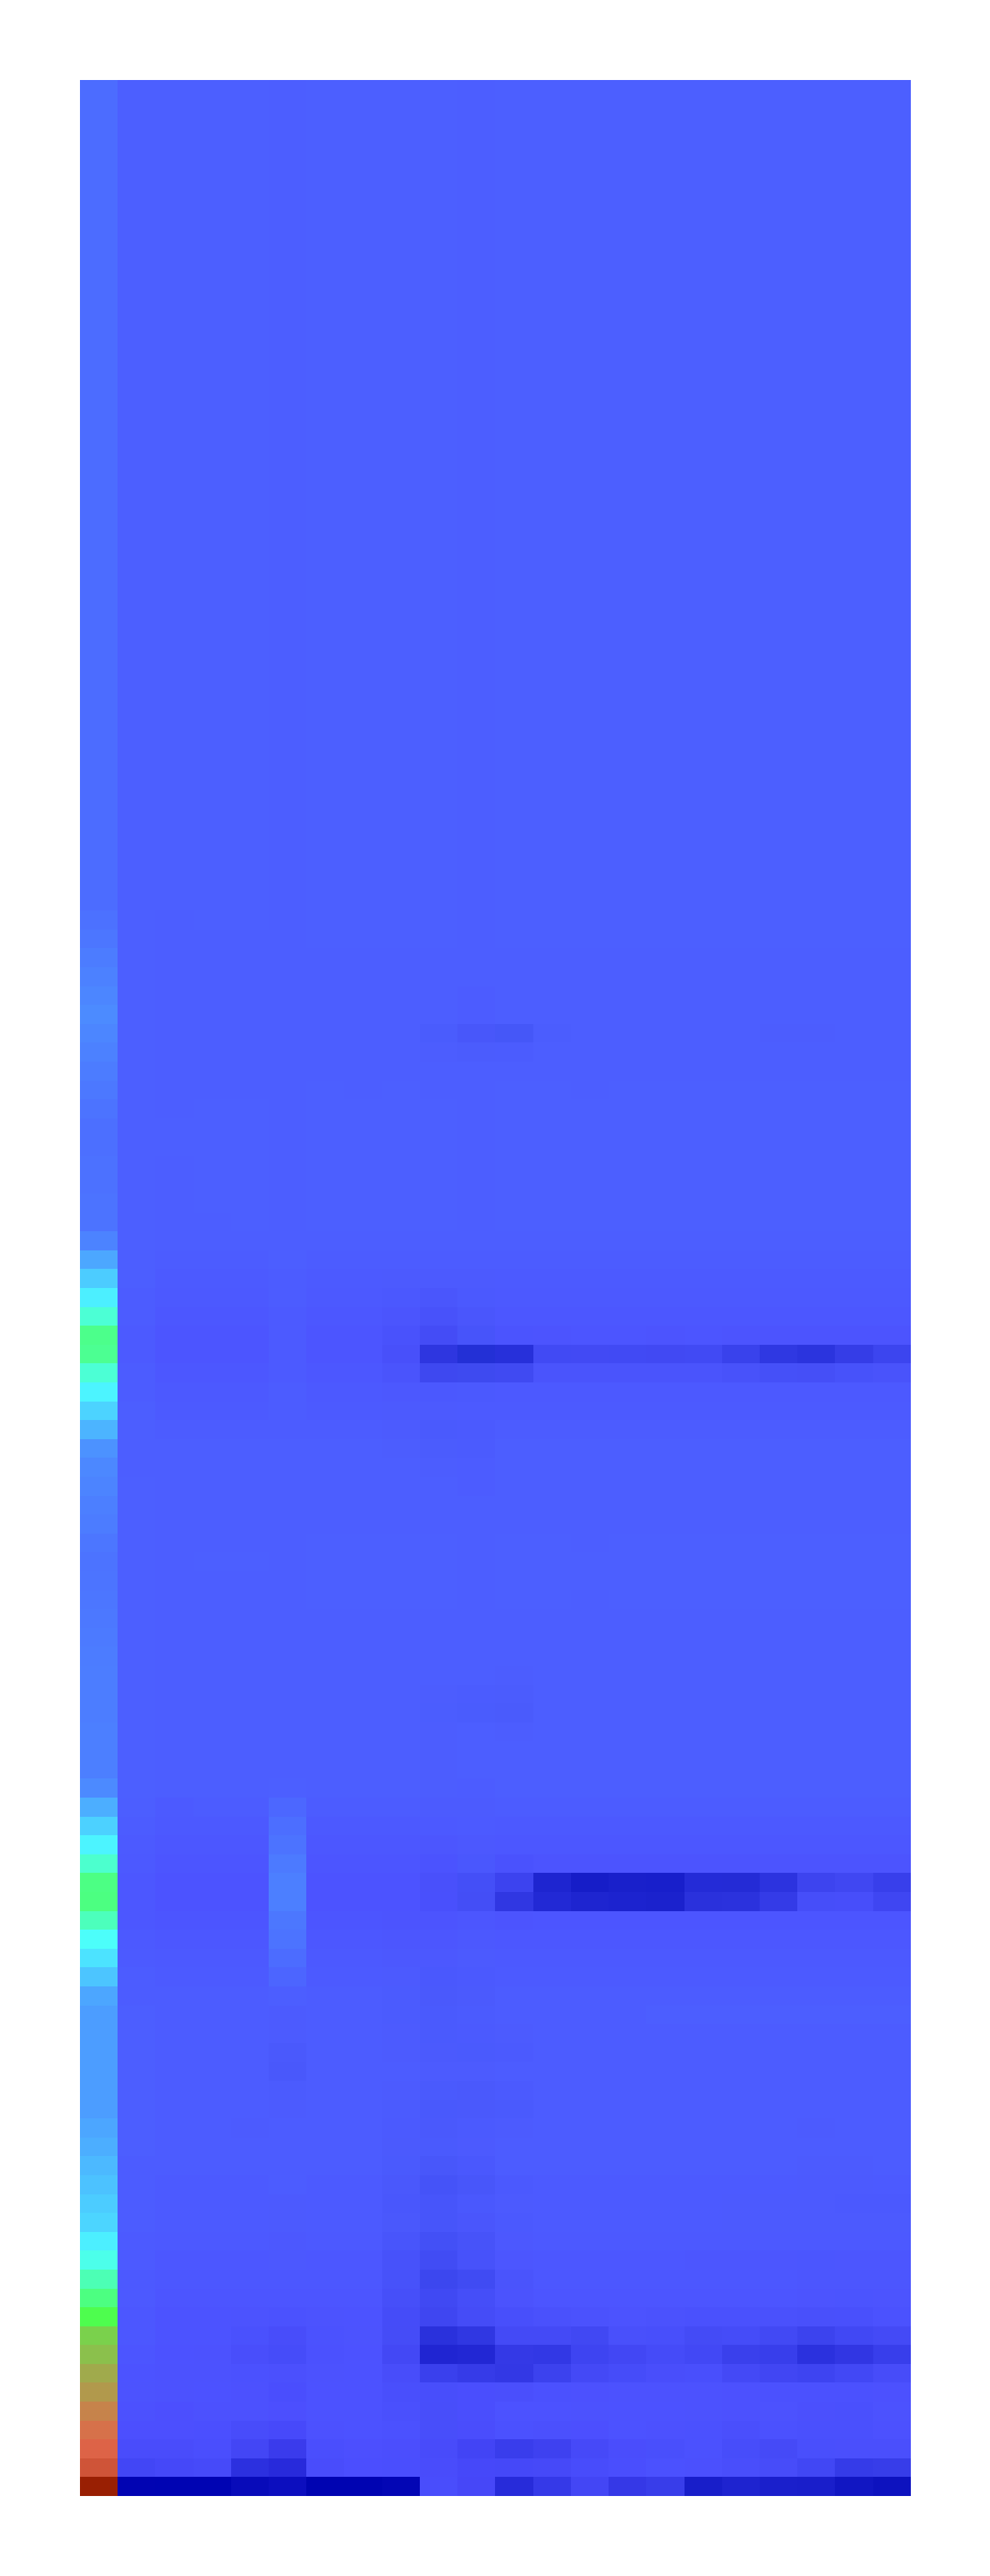

The input class is a guitar_G5_very-long_forte_harmonics and the predicted class is a flute


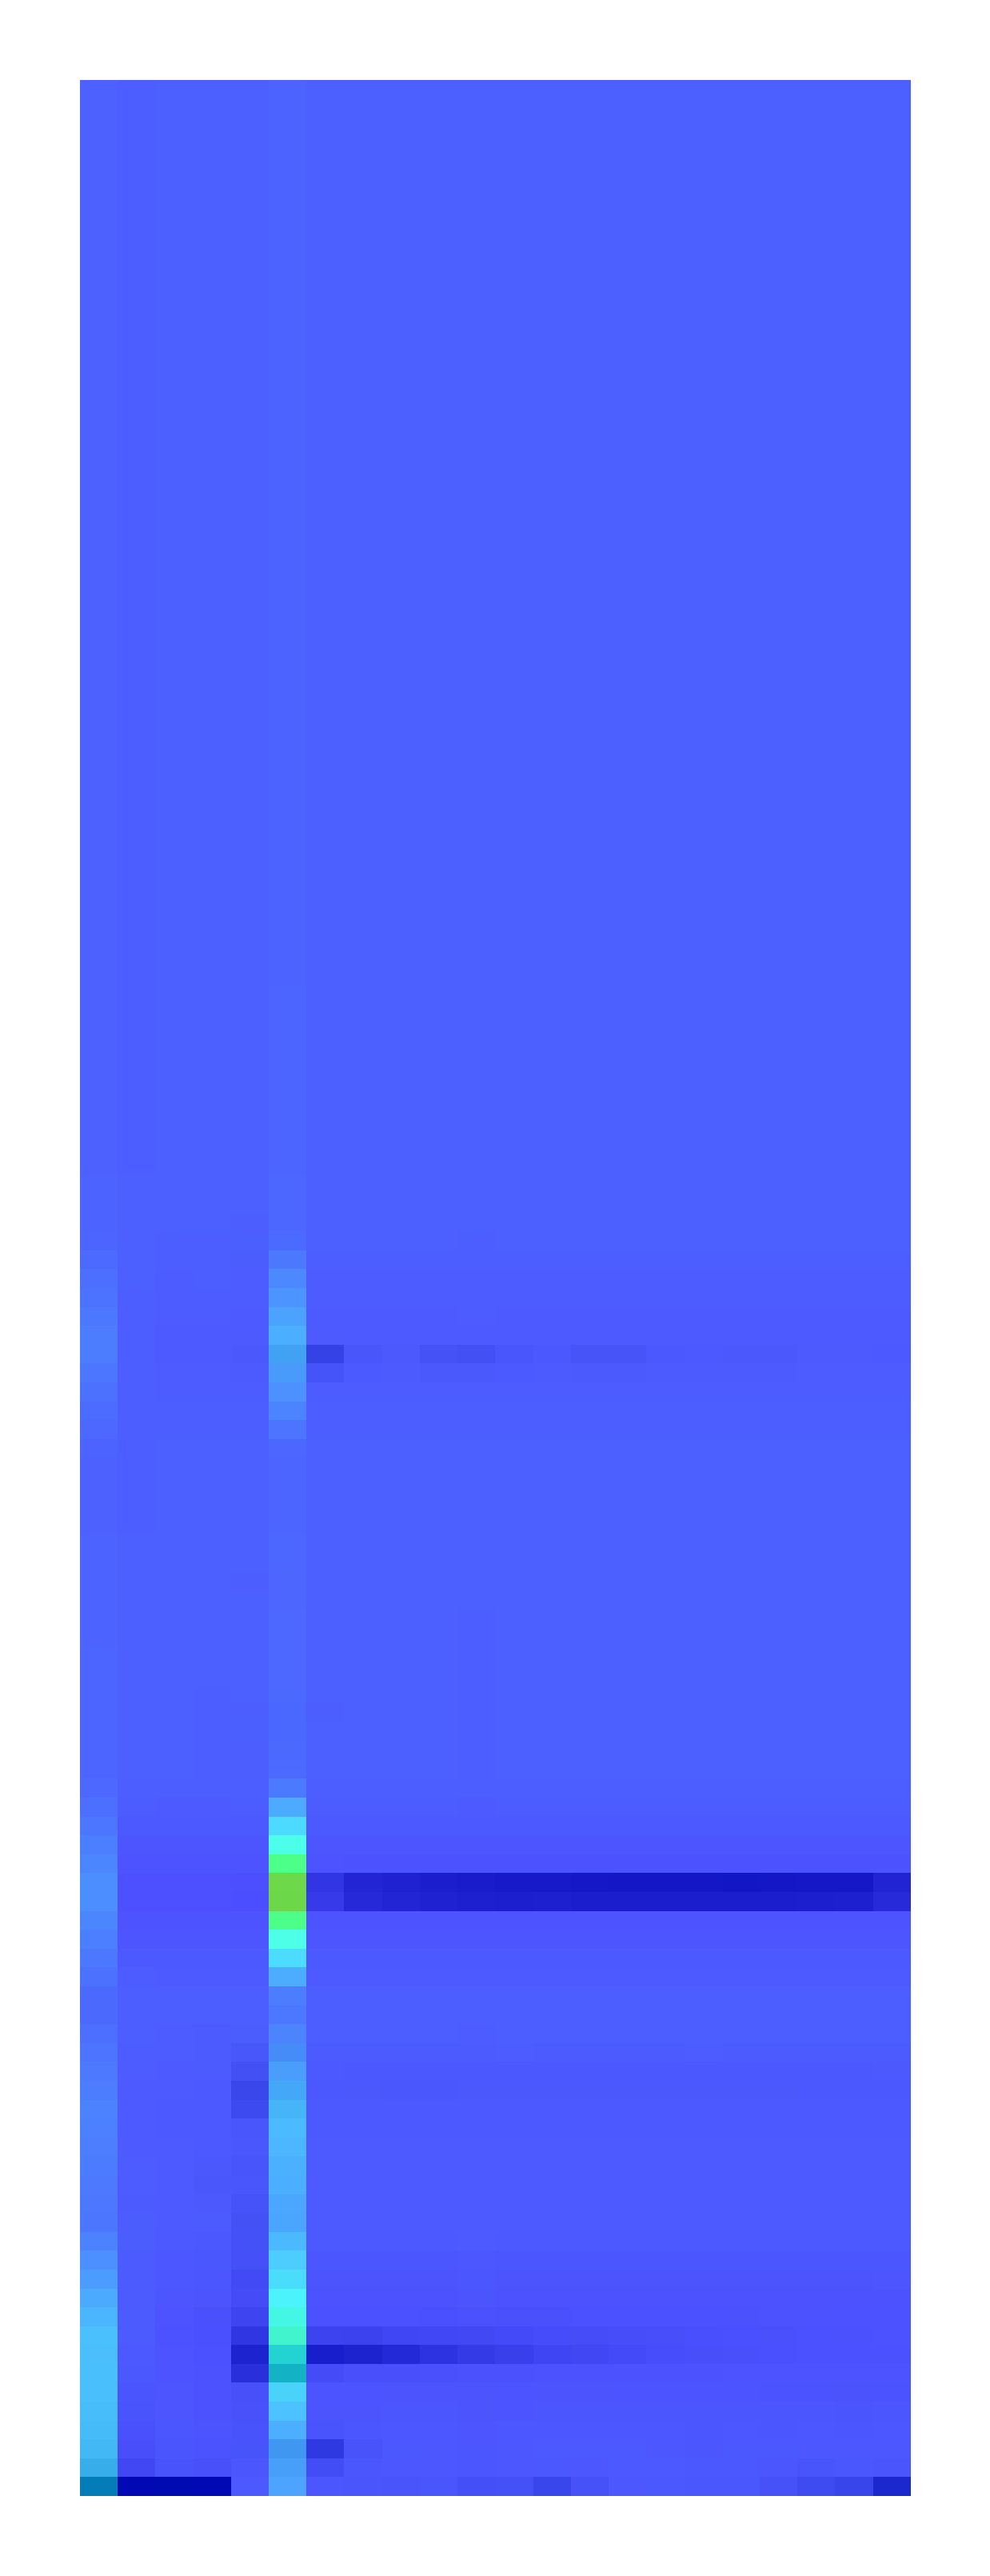

The input class is a guitar_Gs2_very-long_forte_normal and the predicted class is a guitar


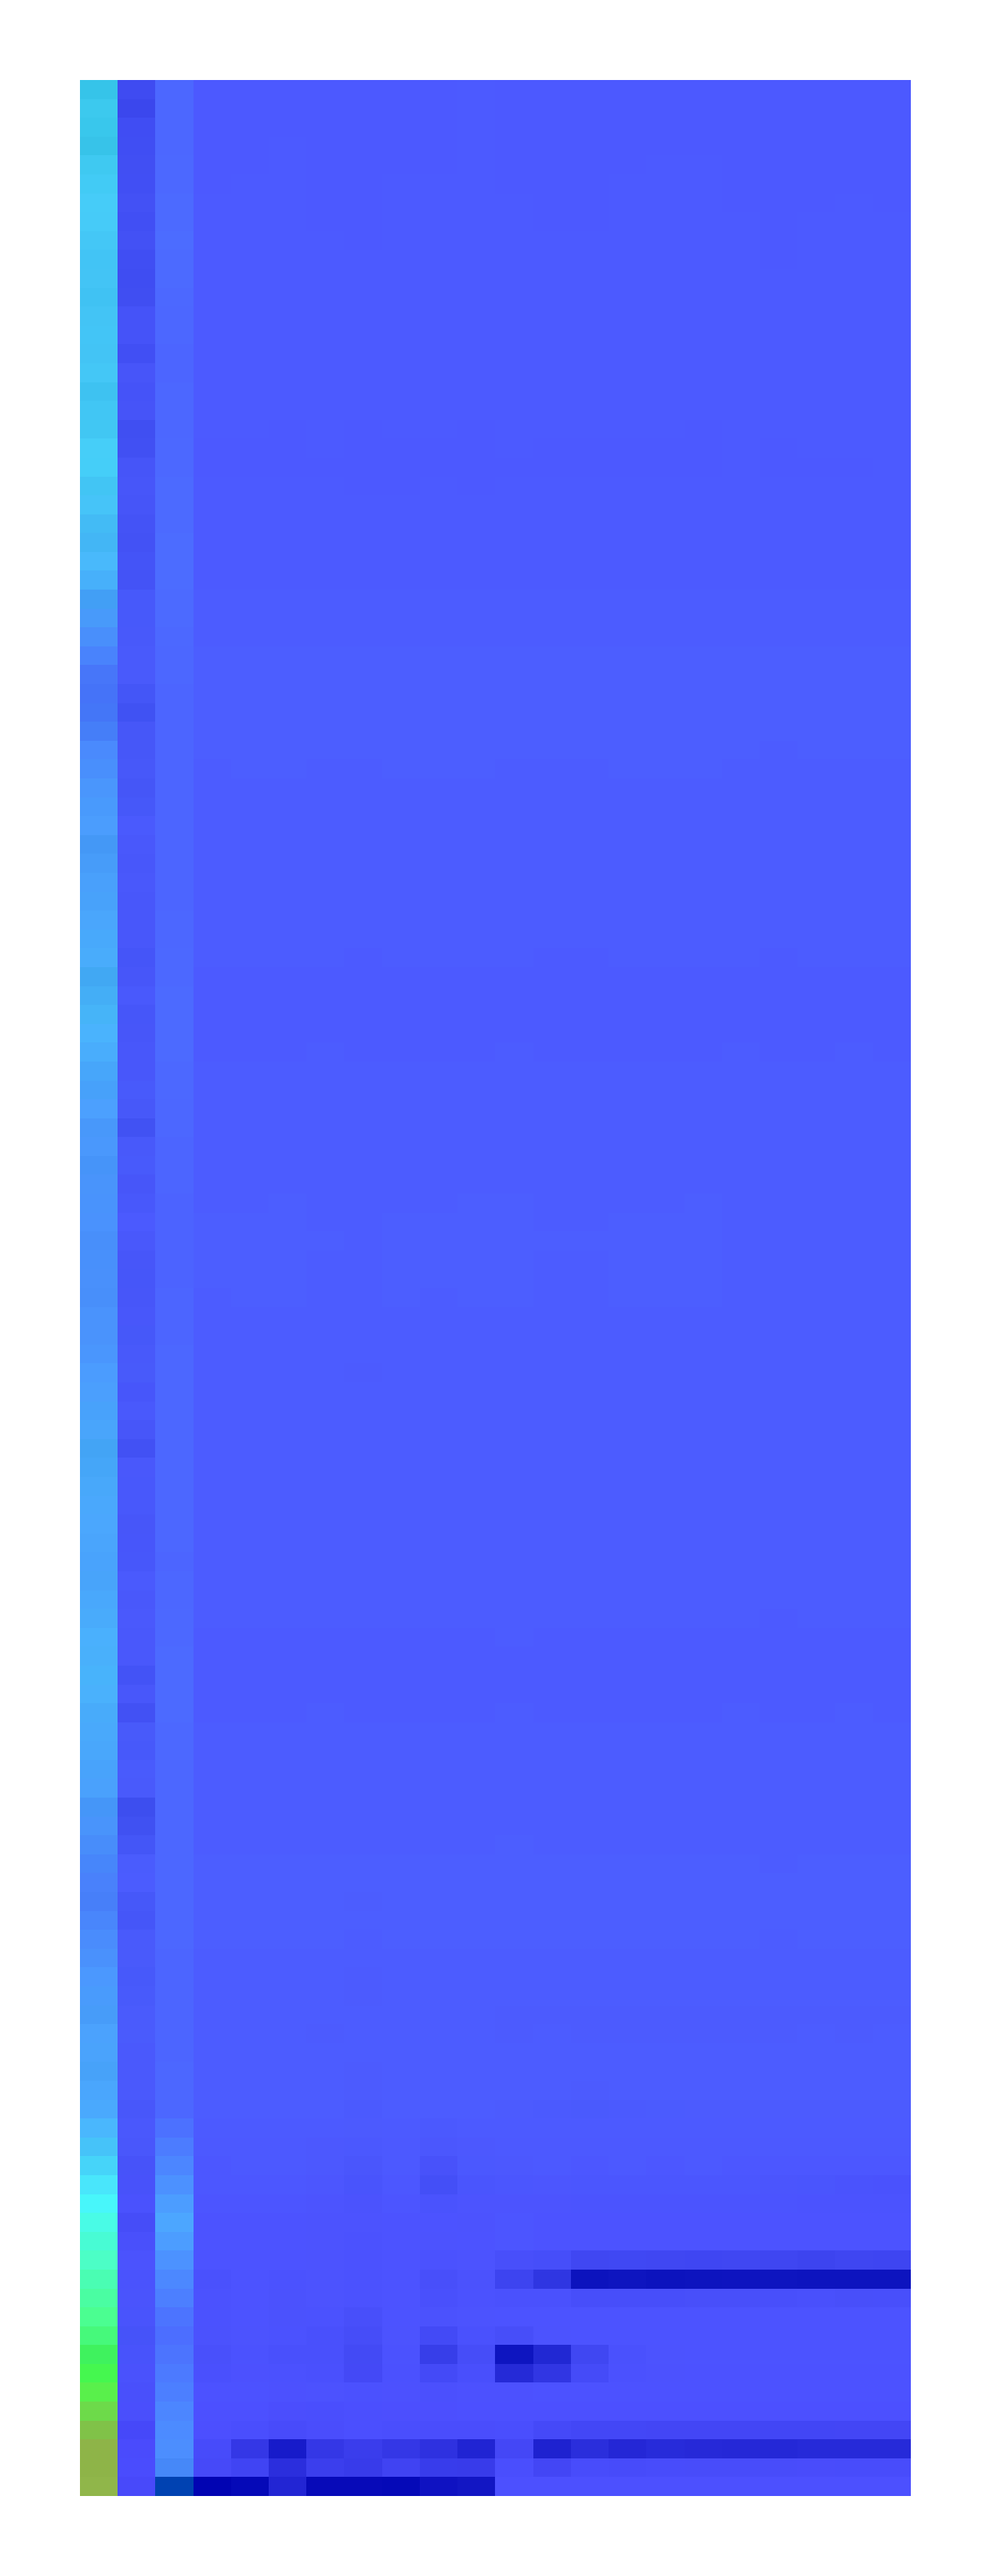

The input class is a guitar_G3_very-long_piano_normal and the predicted class is a guitar


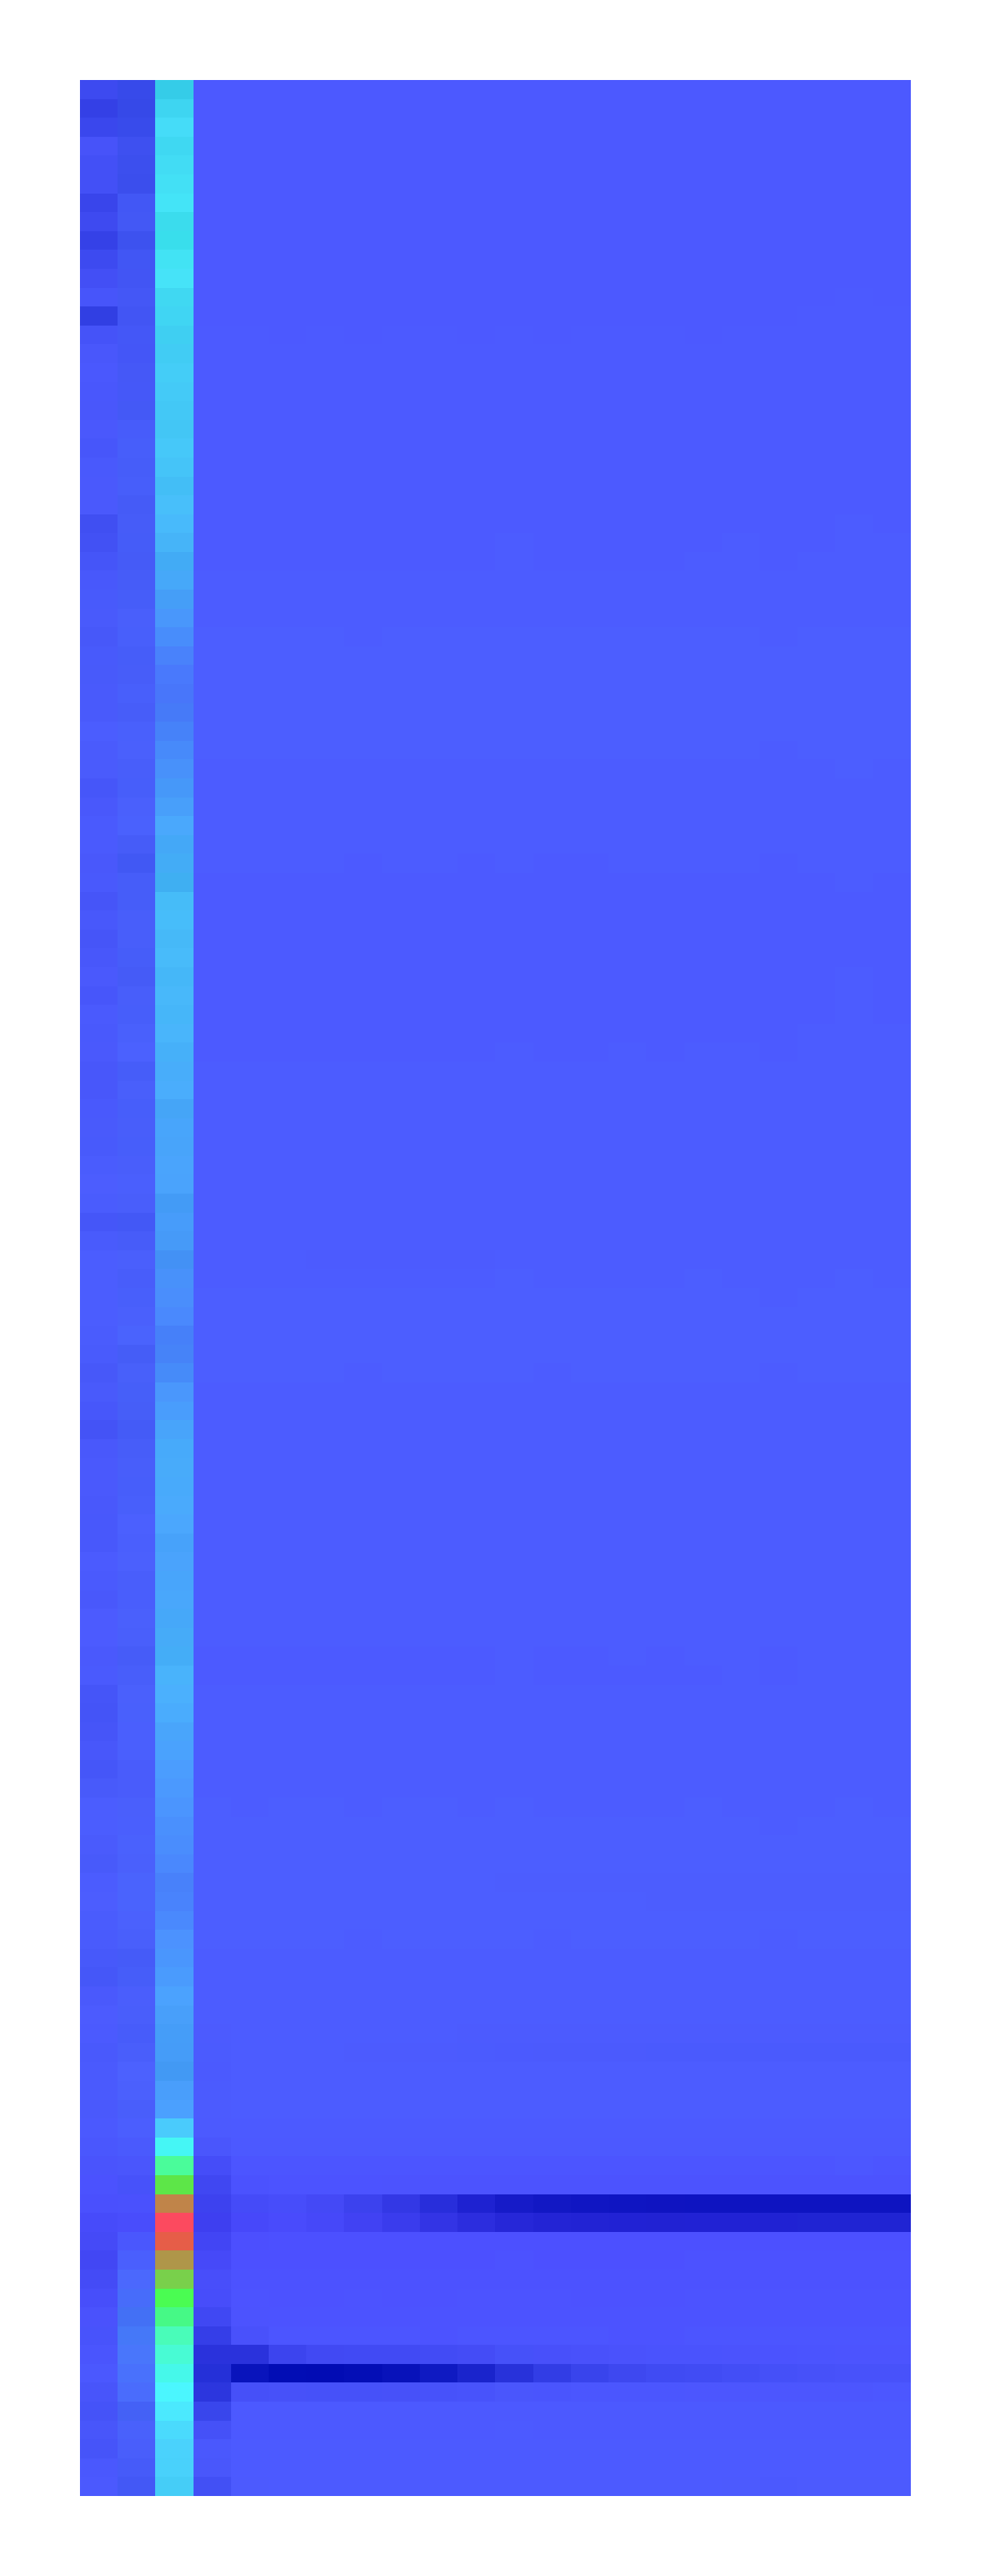

The input class is a guitar_Gs2_very-long_piano_normal and the predicted class is a guitar


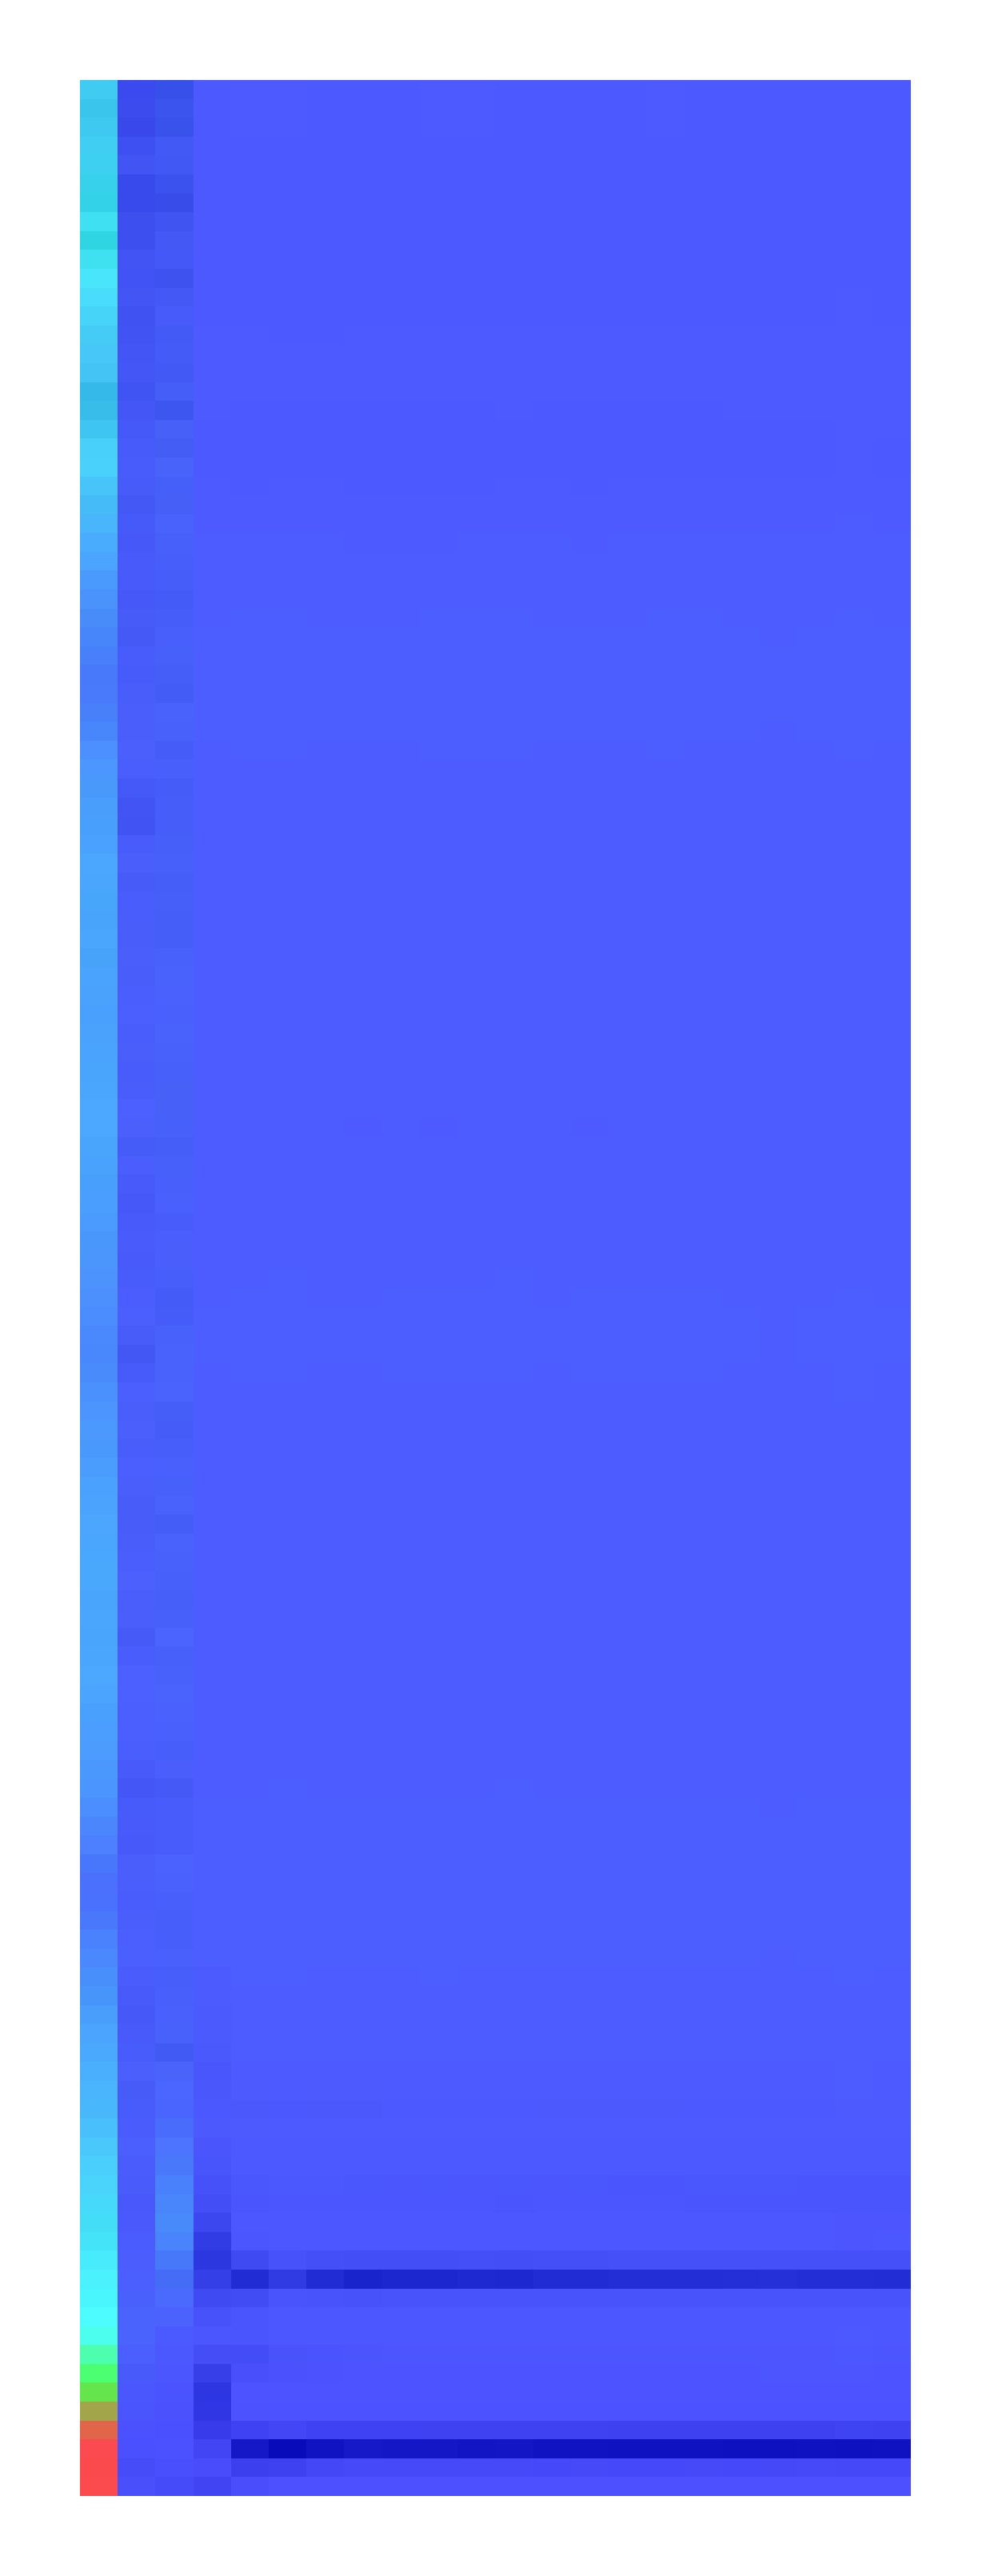

The input class is a guitar_G4_very-long_piano_harmonics and the predicted class is a guitar


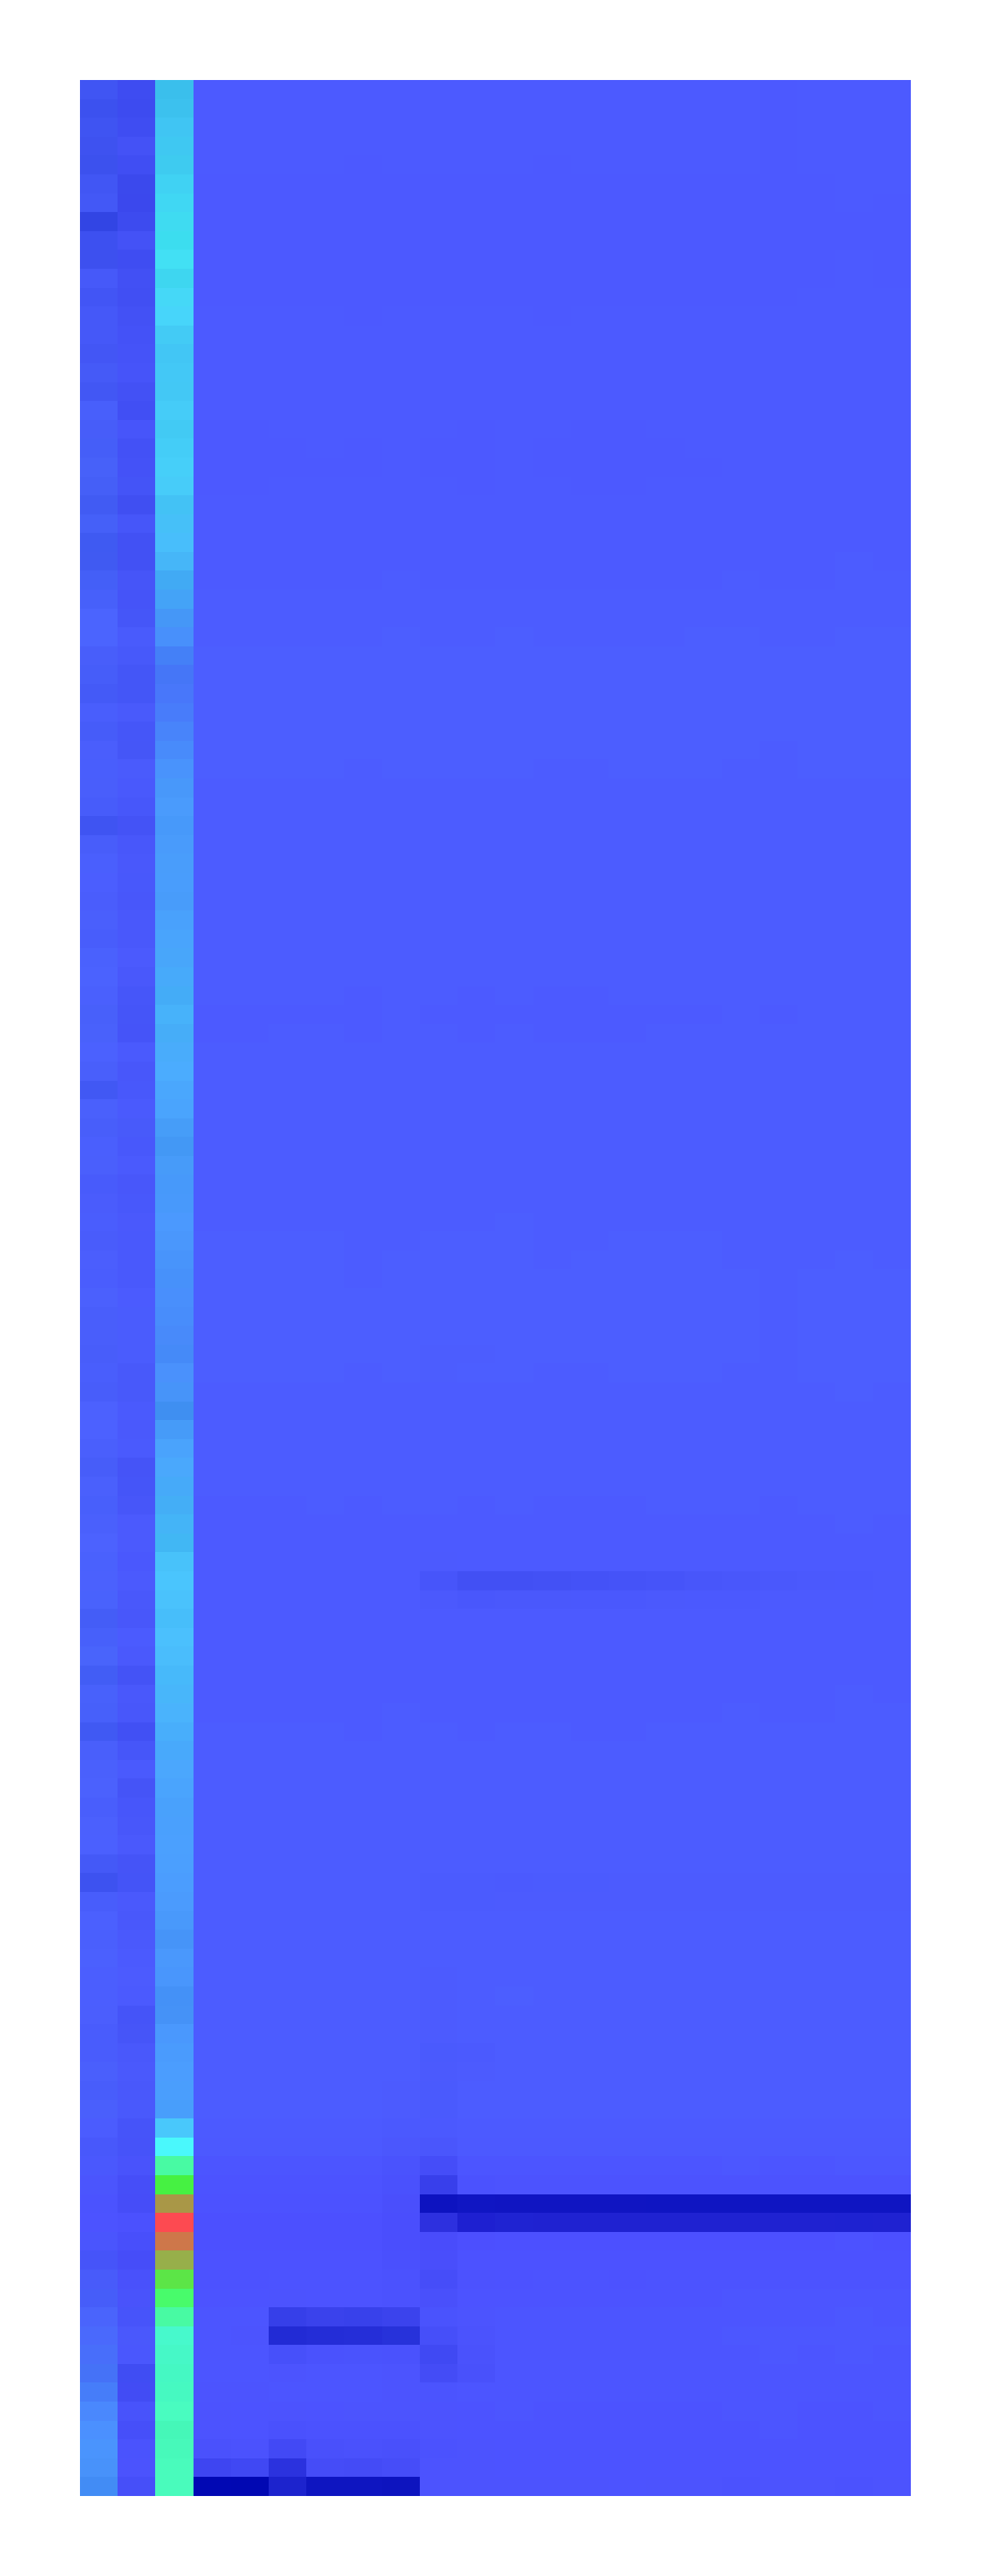

The input class is a guitar_G4_very-long_forte_harmonics and the predicted class is a guitar


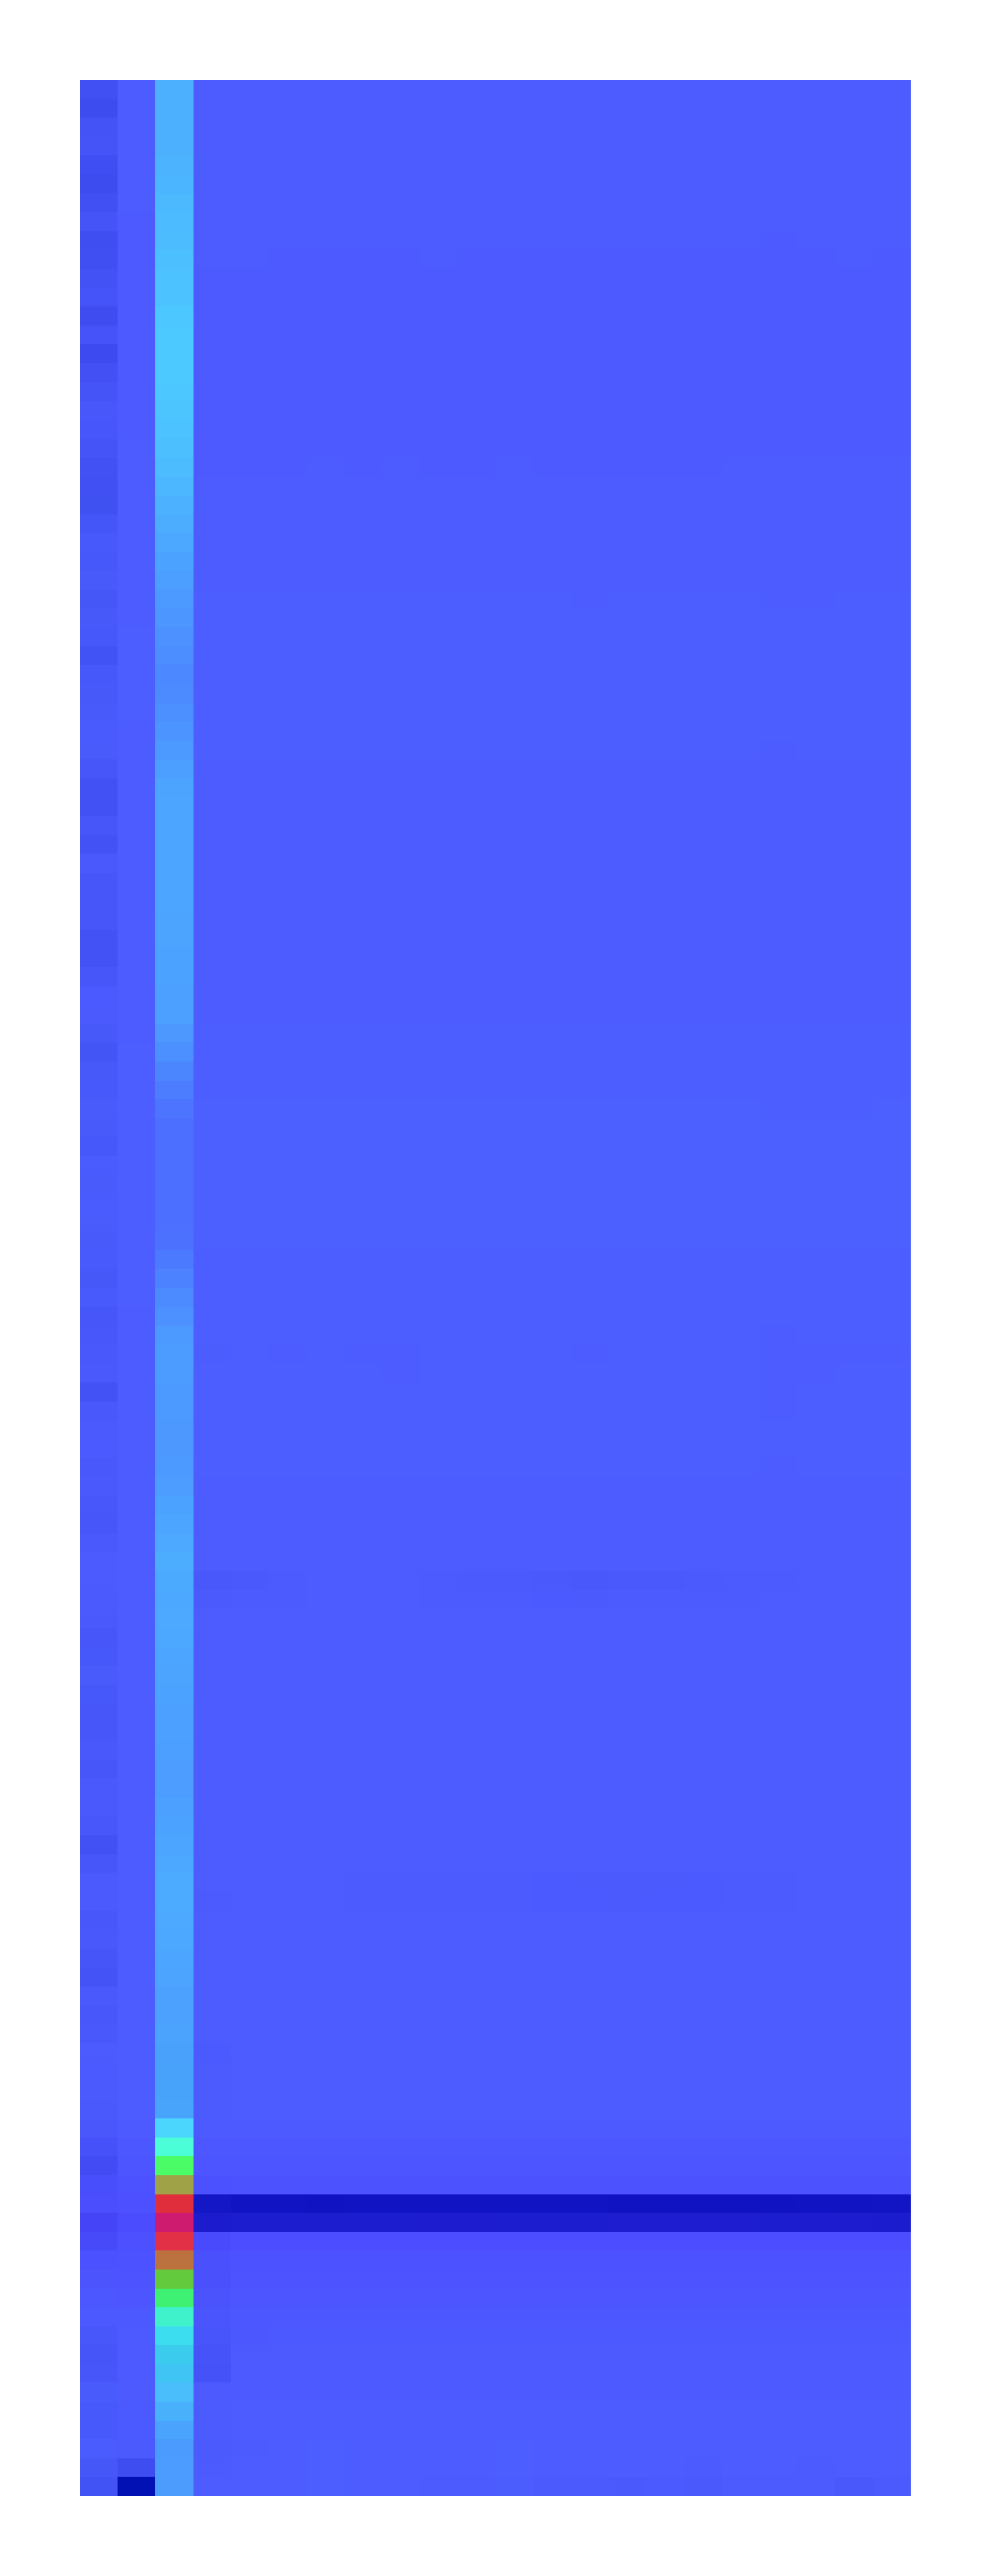

The input class is a guitar_G4_very-long_forte_normal and the predicted class is a guitar


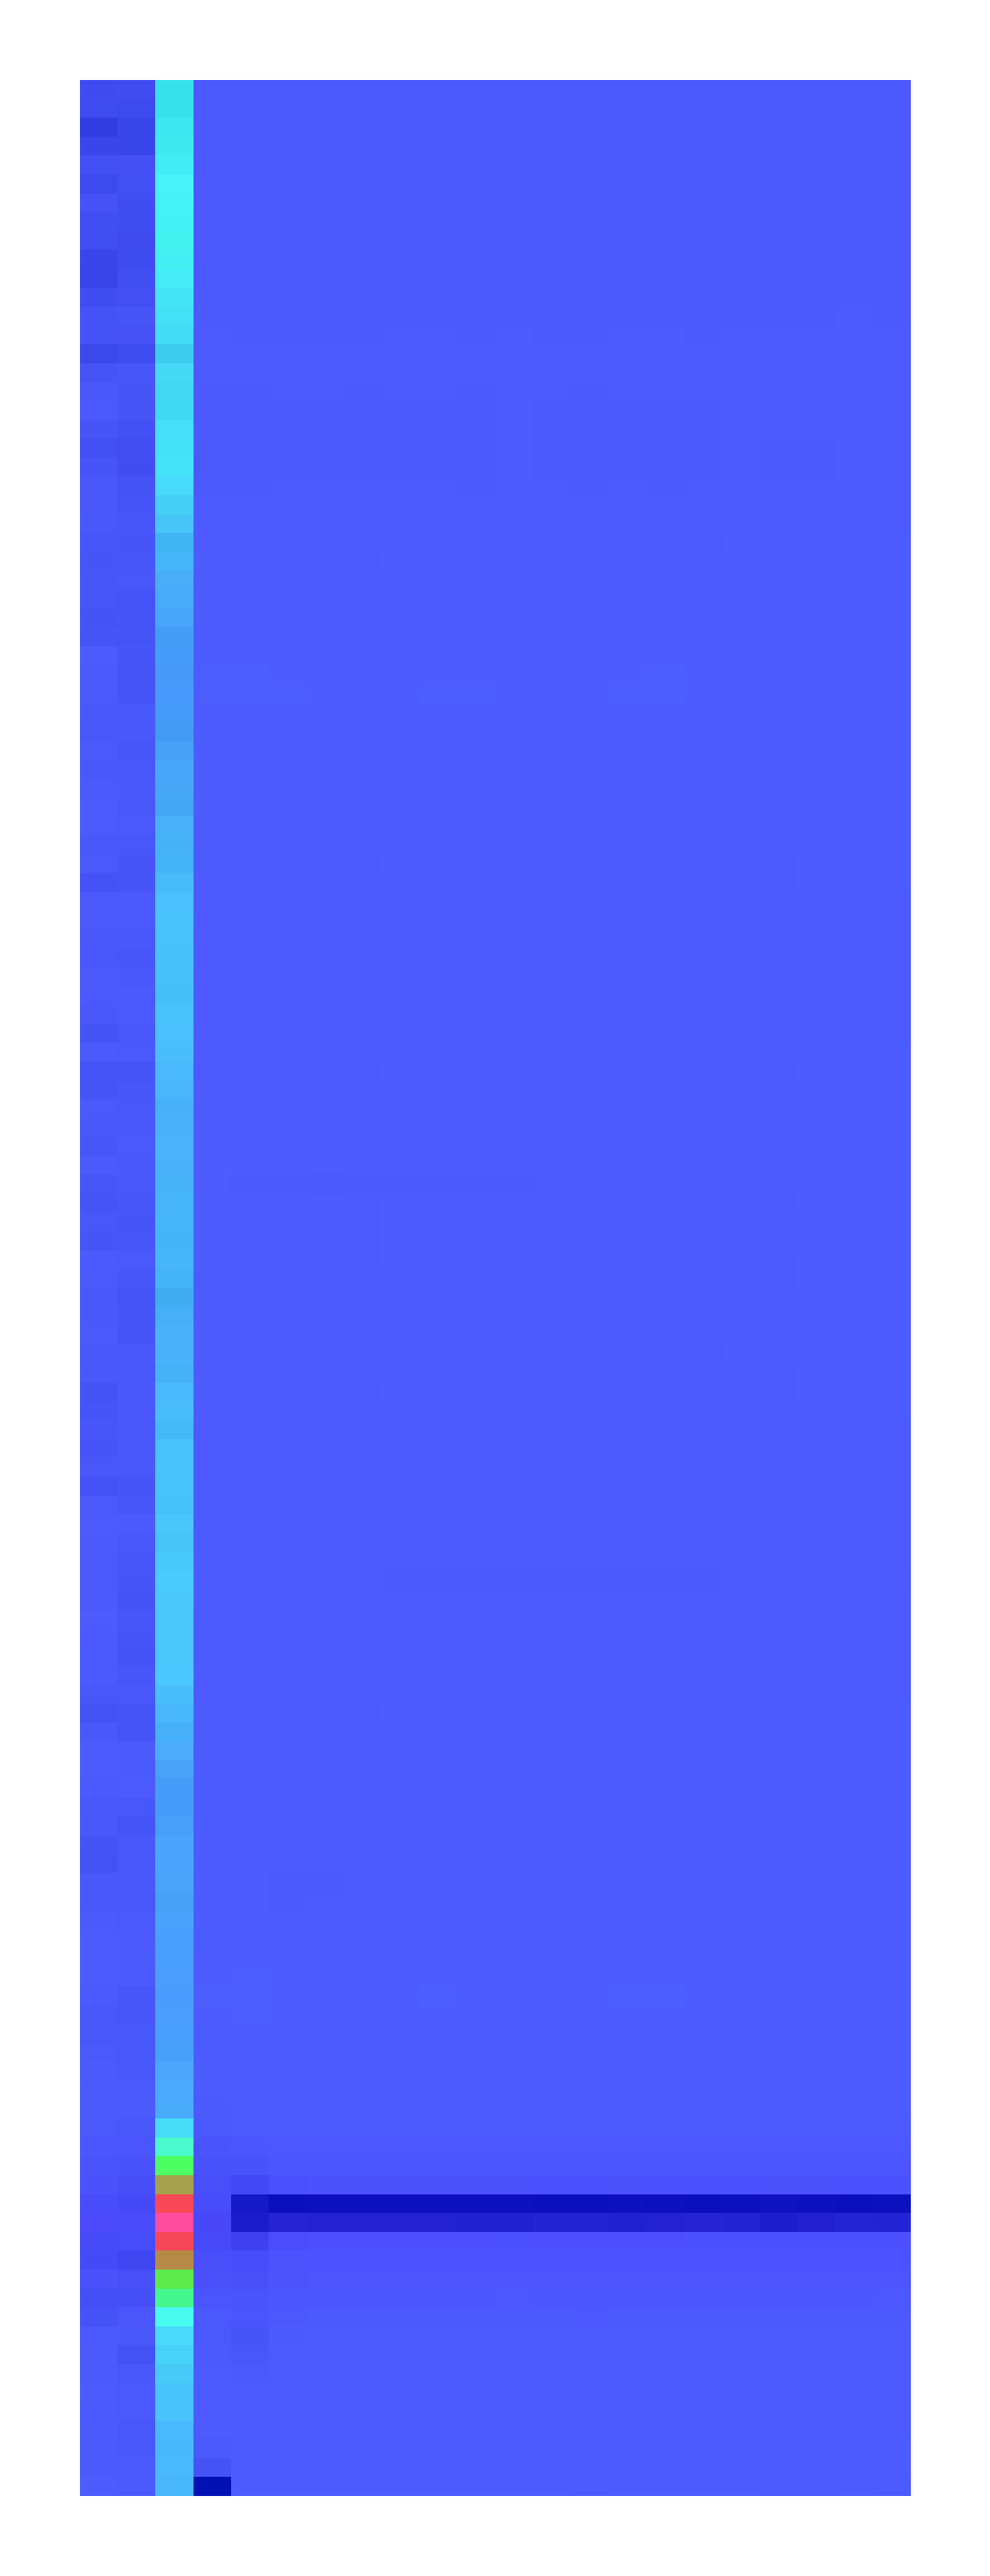

The input class is a guitar_G4_very-long_pianissimo_harmonics and the predicted class is a violin


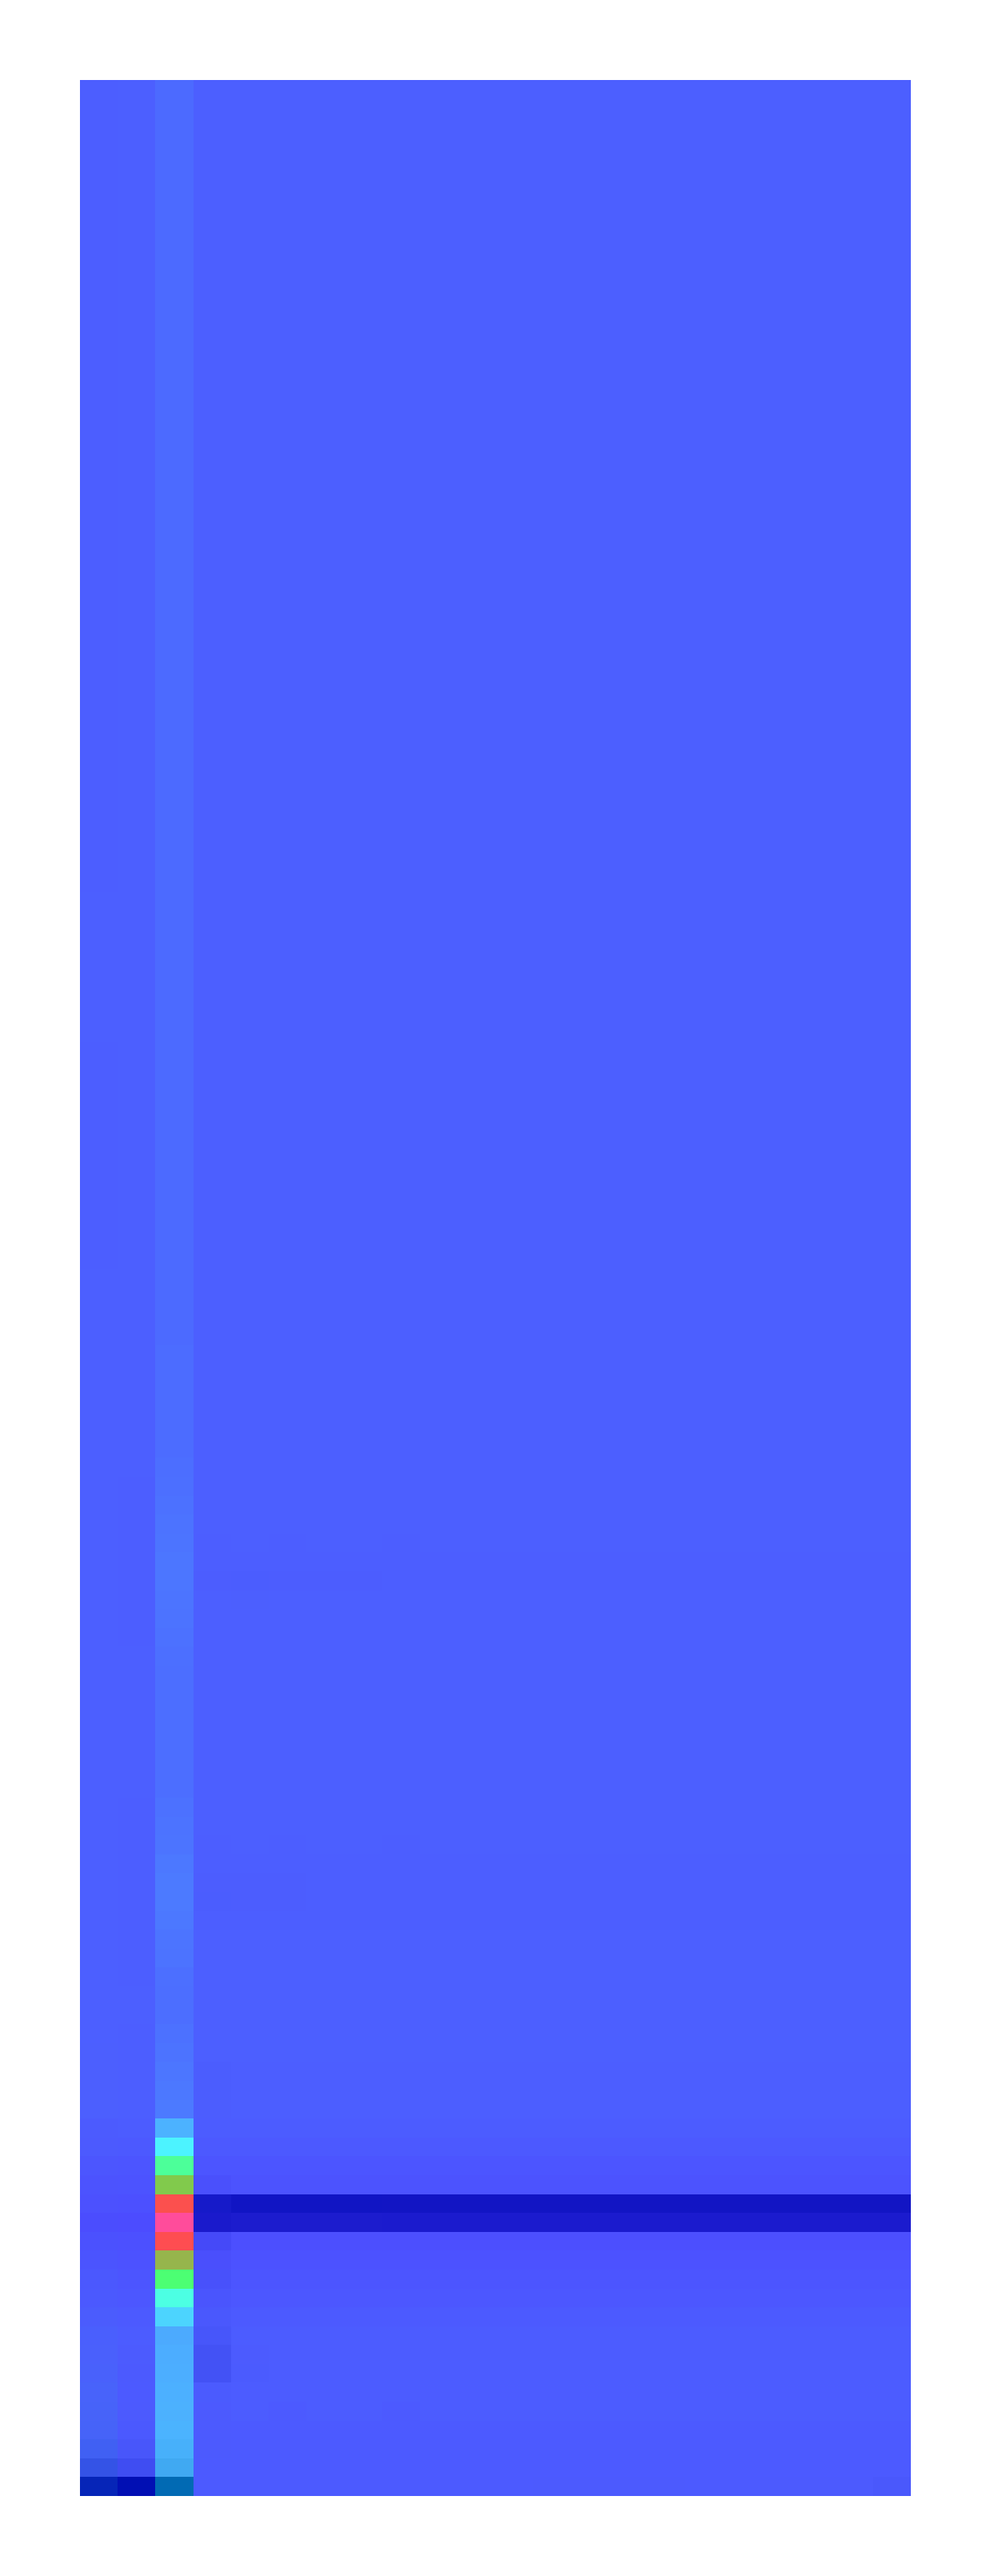

In [18]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import scipy.ndimage as ndimage

with torch.no_grad():
    model.eval()

    for sample_batch, file, y in test_dataloader:
        #if file[0] == 'violin_Gs3_1_mezzo-forte_arco-normal':# or file[0]=='viola_G6_1_fortissimo_arco-normal':
        if file[0].split('_')[0] == 'guitar': #violins
            
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_pred, y_attn, w = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            for key, value in classes_dict.items():
                if y_pred_tags[0] == value:
                    pred_key = key
            print('The input class is a {} and the predicted class is a {}'.format(file[0], pred_key))
            
            #y_attn = y_attn[:,0,:].detach().cpu().numpy()
            #plt.imshow(y_attn.T, origin='lower')
            #plt.show()
            #plt.imshow(w[0,...].detach().cpu().numpy(), origin='lower')
            #plt.show()
                
            y_attn = y_attn[:,0,:].detach().cpu().numpy()
            y_attn = y_attn.T
            #plt.imshow(y_attn, origin='lower')
            #plt.show()
            #plt.imshow(w[0,...].detach().cpu().numpy(), origin='lower')
            #plt.show()


            sample_batch = sample_batch[0,0,...].detach().cpu().numpy()

            weight = w[0,:,...].detach().cpu().numpy()

            #reorder dims
            #weight = np.moveaxis(weight, 1, 0)

            #resize weight to be equal to image size
            heatmap = cv2.resize(weight, (sample_batch.shape[1], sample_batch.shape[0]))
            # Convert dtype to uint8
            heatmap = np.uint8(255 * heatmap)
            # Overlay the heatmap on the image
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
            #heatmap_smooth = ndimage.gaussian_filter(heatmap, sigma=1.0, order=0)

            #add 3 channels dimension
            sample_batch = cv2.cvtColor(1-sample_batch, cv2.COLOR_GRAY2BGR)
            sample_batch = np.uint8(255 * sample_batch)

            result = cv2.addWeighted(sample_batch, 0.3, heatmap, 0.7, 0)#, dtype=cv2.CV_64F)

            
            fig = plt.gcf()
            plt.axis('off')

            plt.imshow(result, origin='lower', aspect=0.5)
            fig.savefig(fname=os.path.join(Path('../plots'), file[0] + '.png'), dpi=1000)
            plt.show()

            #plt.imshow(weight, origin='lower')
            #plt.show()
            

        else:
            continue

In [19]:
att_layer = model._modules.get('fc_1')

In [20]:
model._modules.get('fc_1')

Linear(in_features=2816, out_features=20, bias=True)

In [21]:
activated_features = SaveFeatures(att_layer)

NameError: name 'SaveFeatures' is not defined

In [ ]:
activated_features.remove()

In [ ]:
weight_softmax_params = list(model._modules.get('multihead_attn').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [ ]:
list(model._modules.get('multihead_attn').parameters())[0].shape

In [ ]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [ ]:
with torch.no_grad():
    model.eval()

    for sample_batch, file, y in test_dataloader:
        if file[0] == 'viola_Gs3_15_piano_arco-normal':
            print(sample_batch.shape)
            
            att_layer = model._modules.get('multihead_attn')
            class SaveFeatures():
                features=None
                def __init__(self, m): 
                    self.hook = m.register_forward_hook(self.hook_fn)
                def hook_fn(self, module, input, output): 
                    self.features = ((output).data).numpy()
                def remove(self): 
                    self.hook.remove()
            activated_features = SaveFeatures(att_layer)
            
            
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_pred, _, w = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            for key, value in classes_dict.items():
                if y_pred_tags[0] == value:
                    pred_key = key
            print('The input class is a {} and the predicted class is a {}'.format(file[0], pred_key))
            
            activated_features.remove()
            class_idx = topk(pred_probabilities,1)[1].int()
            weight_softmax_params = list(model._modules.get('fc_1').parameters())
            weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
            print(class_idx)
            overlay = getCAM(activated_features.features, weight_softmax, class_idx )
            plt.imshow(overlay[0], alpha=0.5, cmap='jet')
            plt.show()
        else:
            continue

In [ ]:
model

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.multihead_attn.register_forward_hook(get_activation('multihead_attn'))
x = torch.randn(1, 1, 128, 22)
x = x.to(device)
output = model(x)
act = activation['multihead_attn'].squeeze()
num_plot = 4
fig, axarr = plt.subplots(min(act.size(0), num_plot))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

In [ ]:
act = activation['multihead_attn'].squeeze()
num_plot = 4
fig, axarr = plt.subplots(min(act.size(0), num_plot))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].imshow(act[idx])

The input class is a viola_Gs3_15_piano_arco-normal and the predicted class is a viola


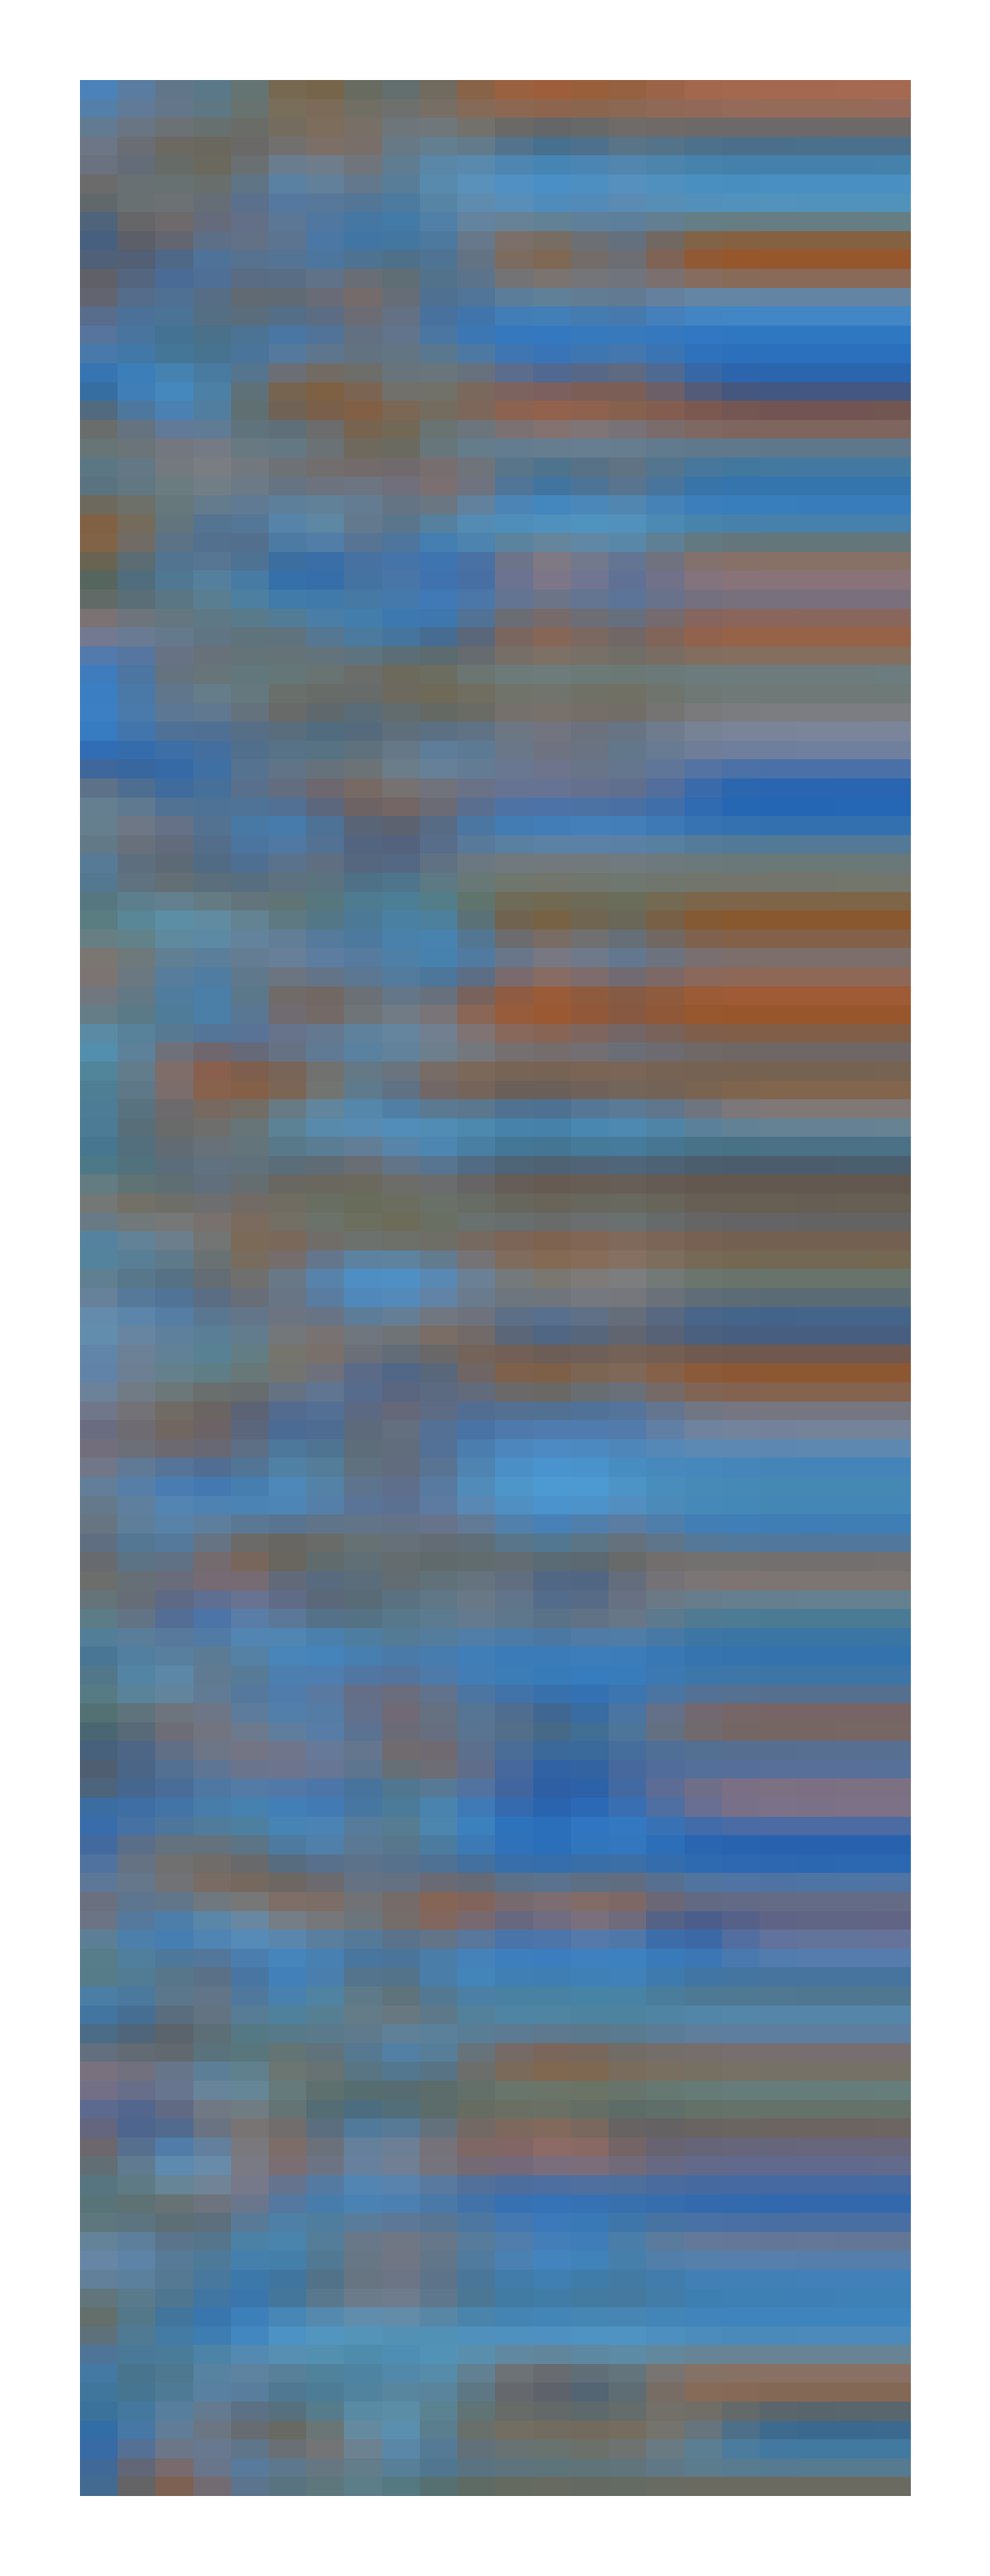

In [34]:
with torch.no_grad():
    model.eval()

    for sample_batch, file, y in test_dataloader:
        if file[0] == 'viola_Gs3_15_piano_arco-normal':
            
            sample_batch = sample_batch.to(device, dtype=torch.float)
            y_test_pred, y_attn, _ = model(sample_batch)
            _, y_pred_tags = torch.max(y_test_pred, dim = 1)
            for key, value in classes_dict.items():
                if y_pred_tags[0] == value:
                    pred_key = key
            print('The input class is a {} and the predicted class is a {}'.format(file[0], pred_key))
            
            y_attn = y_attn[:,0,:].detach().cpu().numpy()
            y_attn = y_attn.T
            heatmap = np.uint8(255 * y_attn)
            # Overlay the heatmap on the image
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
            heatmap_smooth = ndimage.gaussian_filter(heatmap, sigma=1.0, order=0)
            
            fig = plt.gcf()
            plt.axis('off')

            plt.imshow(heatmap_smooth, origin='lower', aspect=0.5)
            #fig.savefig(fname=os.path.join(Path('../plots'), file[0] + '.png'), dpi=1000)
            plt.show()
            
            
        else:
            continue

## References

* https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab